In [1]:
library(Seurat)
library(dplyr)
library(Matrix)
library(stringr)
library(pheatmap)
# library(CellChat)
library(data.table)
library(RColorBrewer)
library(parallel)
library(tidyverse)
require(ggplotify)
# library(ggalluvial)
# library(networkD3)
# library(UpSetR)
library(ggrepel)
# library (VennDiagram)
# library(GOplot)
# library(msigdbr)
library(ggplot2)
library(patchwork)
library(enrichplot)
library(org.Mm.eg.db)
library(org.Hs.eg.db)
library(clusterProfiler) 
# library(epiDisplay)
# library(epitools)


Attaching SeuratObject

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ data.table::between() masks dplyr::between

# Unbias

In [2]:
human = read.csv('/home/zhaoyp/collaboration/haorui/humanCd8.csv',sep=' ')
human = human[which( human[,'p']<0.05),]
human = human[which(human[,'OR']!=0 ),] 
human = human[which(is.finite(human$OR)),]
human = human[which(human[,'OR']<1),]


In [3]:
mouse = read.csv("/home/zhaoyp/collaboration/haorui/result_0.1_1197_genes_Cd8.csv",sep=' ')
mouse = mouse[which(mouse[,'p']<0.05),]
mouse = mouse[which(mouse[,'OR']!=0),]
mouse = mouse[which(is.finite(mouse$OR)),]
mouse = mouse[which(mouse[,'OR']<1),]


In [4]:
mouse.human <- read.csv('/home/zhaoyp/collaboration/haorui/0.NatMed_Tatlas_lh/Complete List of Human and Mouse Homologs_FromMGI_version_09 May 2023.csv', check.names = FALSE)
mouse.human <- mouse.human[,c(1,2,4)]
colnames(mouse.human) <- c('DB Class Key', 'Common Organism Name', 'Symbol')
mouse.human <- mouse.human %>% pivot_wider(names_from = 'DB Class Key', values_from = "Symbol") %>% t()
mouse.human <- data.frame(mouse.human)[-1,]
mouse.human <- mouse.human[mouse.human[,1] %in% unique(c(mouse[,1], mouse[,2])), ]


Warning message:
“Values from `Symbol` are not uniquely identified; output will contain
list-cols.
• Use `values_fn = list` to suppress this warning.
• Use `values_fn = {summary_fun}` to summarise duplicates.
• Use the following dplyr code to identify duplicates.
  {data} %>%
  dplyr::group_by(`Common Organism Name`, `DB Class Key`) %>%
  dplyr::summarise(n = dplyr::n(), .groups = "drop") %>%
  dplyr::filter(n > 1L)”


In [5]:
two_genes_com = data.frame(matrix(nrow=nrow(mouse)*2,ncol=6))
colnames(two_genes_com) <- c('mouse.gene1','mouse.gene2','mouse.Or','mouse.Pvalue','gene1','gene2')
k=1 
for (i in 1:nrow(mouse)){
    mouse.gene1 <- mouse[i,1]
    mouse.gene2 <- mouse[i,2]
    genes1 <- mouse.human[mouse.human[,1] == mouse.gene1,2]
    genes2 <- mouse.human[mouse.human[,1] == mouse.gene2,2]
    # print(genes1) 
    # print(genes2) 
    # print('===========')
    if (length(genes1)==0 ){next}
    if (length(genes2)==0) {next}
    genes1 <- genes1[[1]]
    genes2 <- genes2[[1]]
    if (length(genes1)==0 ){next}
    if (length(genes2)==0) {next}
    for (m in 1:length(genes1)){
        for (n in 1:length(genes2)){
            # print(1)
            two_genes_com[k,5] <- genes1[m]
            two_genes_com[k,6] <- genes2[n]
            two_genes_com[k,1] <- mouse.gene1
            two_genes_com[k,2] <- mouse.gene2
            two_genes_com[k,3] <- mouse[i,3]
            two_genes_com[k,4] <- mouse[i,4]
            k=k+1
        }
    }
}
two_genes_com <- na.omit(two_genes_com)
two_genes_com <- unique(two_genes_com)


In [6]:
colnames(two_genes_com) <- c('mouse.gene1',	'mouse.gene2', 'mouse.Or', 'mouse.Pvalue', 'TransGene1', 'TransGene2') 
two_genes_com$pair = paste0(two_genes_com$TransGene1, '_', two_genes_com$TransGene2)
head(two_genes_com)


,mouse.gene1,mouse.gene2,mouse.Or,mouse.Pvalue,TransGene1,TransGene2,pair
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,Rack1,Gclm,0.004021963,0,RACK1,GCLM,RACK1_GCLM
2,Selenow,Gclm,0.005310075,0,SELENOW,GCLM,SELENOW_GCLM
3,Sem1,Gclm,0.006030130,0,SEM1,GCLM,SEM1_GCLM
4,Gclm,Elob,0.006201012,0,GCLM,ELOB,GCLM_ELOB
5,Gclm,Arhgap45,0.006400630,0,GCLM,ARHGAP45,GCLM_ARHGAP45
6,Gclm,Cd37,0.006694104,0,GCLM,CD37,GCLM_CD37


In [7]:
human$pair <- paste0(human$gene1, '_', human$gene2)
human$pair1 <- paste0(human$gene2, '_', human$gene1)
df1 <- merge(two_genes_com, human, by='pair', all=TRUE) 
df2 <- merge(two_genes_com, human, by.x='pair', by.y='pair1', all=TRUE) 
colnames(df1) <- c('pair',	'mouse.gene1',	'mouse.gene2',	'mouse.Or',	'mouse.Pvalue',	'TransGene1',	'TransGene2',	'HumanGene1',	'HumanGene2',	'HumanOR', 'Human.Pvalue', 'HumanPair')
colnames(df2) <- c('pair',	'mouse.gene1',	'mouse.gene2',	'mouse.Or',	'mouse.Pvalue',	'TransGene1',	'TransGene2',	'HumanGene1',	'HumanGene2',	'HumanOR', 'Human.Pvalue', 'HumanPair')
df = rbind(df1, df2)

df = df[,c('mouse.gene1',	'mouse.gene2',	'mouse.Or',	'mouse.Pvalue', 'HumanGene1',	'HumanGene2',	'HumanOR', 'Human.Pvalue')]
df <- distinct(df)

# df <- df[which(df[,'HumanGene2']!='NME1-NME2' & df[,'HumanGene1']!='NME1-NME2') ,]
# df <- df[which(df[,'HumanGene2']!='GCLM' & df[,'HumanGene1']!='GCLM') ,]


In [8]:
human <- which(! is.na(df['HumanOR'] ))
mouse <- which(! is.na(df['mouse.Or'] ))

# output_file <- "/home/zhaoyp/collaboration/haorui/res/human.mouse.intersection.pdf"
# pdf(output_file, width = 7, height = 7)  # 设定图像尺寸

venn1 <- venn.diagram(x=list(human, mouse),filename = NULL,
             fill=c('palevioletred2','skyblue3'), category.names = c("Human", "Mouse"), scale=TRUE, lwd=1,#width = 1200,height = 1000,resolution = 600,
             cex = 1, fontface = "bold", cat.default.pos = "outer", cat.pos = -180, cat.cex = 2, cat.fontface = "bold"
) 

# venn1 <- venn.diagram(x=list(human, mouse),filename = NULL,
#              fill=c('#1f4fa1','#e83217'), category.names = c("Human", "Mouse"), scale=TRUE, lwd=1,#width = 1200,height = 1000,resolution = 600,
#              cex = 1, fontface = "bold", cat.default.pos = "outer", cat.pos = -180, cat.cex = 2, cat.fontface = "bold"
# ) 

pdf('/home/zhaoyp/collaboration/haorui/res/human.mouse.intersection.pdf', width = 5, height = 5)
grid.draw(venn1)
dev.off()


ERROR: Error in venn.diagram(x = list(human, mouse), filename = NULL, fill = c("palevioletred2", : could not find function "venn.diagram"


In [9]:
df <- na.omit(df) 


Warning message:
“ggrepel: 569 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


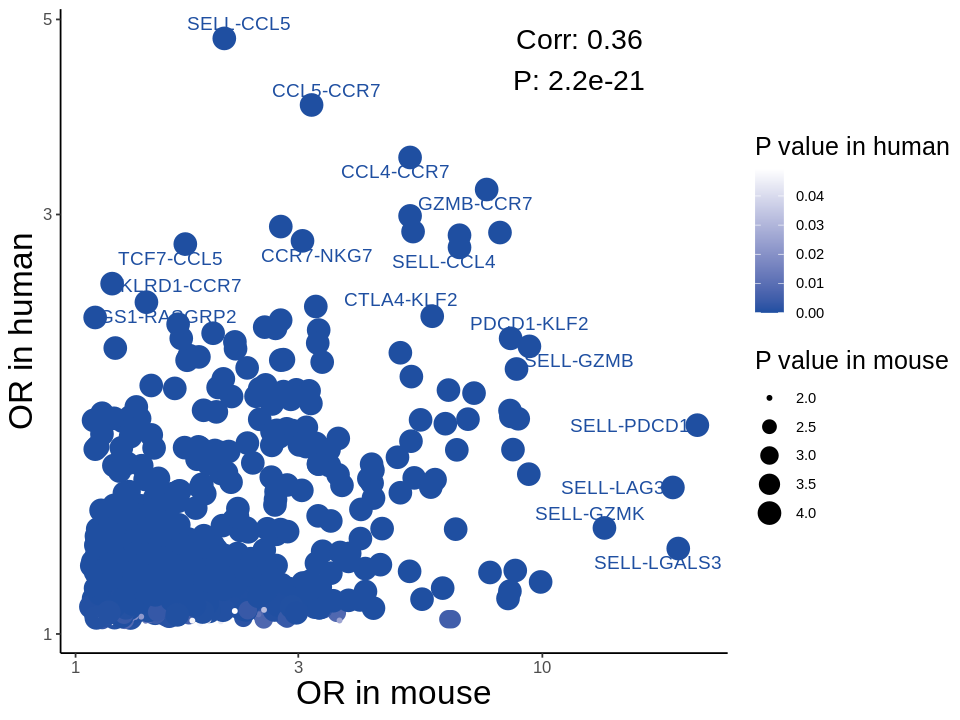

In [10]:
options(repr.plot.width = 8, repr.plot.height = 6)
ref = df
colnames(ref) = c('mouse.gene1','mouse.gene2','mouse.Or','mouse.Pvalue','gene1','gene2','OR','p')
ref$size <- ifelse(ref$p<=0.05, ifelse(ref$p<=0.01,ifelse(ref$p<0.001,4,3),2), 1)
cor_result <- cor.test(ref$mouse.Or, ref$OR)
p_value <- cor_result$p.value 
formatted_p_value <- format(p_value, scientific = TRUE, digits = 2)

p <- ggplot(ref, aes(x=1/mouse.Or, y=1/OR, size=size, colour=p )) + 
    geom_point() + 
    theme_classic() + 
    scale_color_gradient( high = "white", low = "#1f4fa1") + 
    geom_text_repel(data=subset(ref, (ref$mouse.Pvalue<=0.01) & (ref$p<=0.01) & (ref$OR<1) & (ref$mouse.Or<1)),aes(label=paste0(gene1,'-',gene2)), size=4,
                    max.overlaps = 5  ) +
    theme( axis.text = element_text(size = 10), axis.title = element_text(size = 20), legend.title = element_text(size = 15)  ) +
    labs( x = "OR in mouse", y = "OR in human", color = "P value in human", size='P value in mouse') + #title = "示例图"
    annotate('text', x=12, y=4.5, label=paste0('Corr: ', round(cor_result$estimate,2), '\nP: ', formatted_p_value), size=6 ) + 
    scale_x_log10() + scale_y_log10() 
p


In [11]:
ggsave( '/home/zhaoyp/collaboration/haorui/res/exclude_pair_corr.pdf', width=7, height=5 ) 


Warning message:
"ggrepel: 575 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


In [12]:
write.csv(df,'/home/zhaoyp/collaboration/haorui/UnbiasMouseHumanCd8All.csv')


In [11]:
mouse_genes <- unique(c(ref[,c(1)], ref[,2]))
human_genes <- unique(c(ref[,c(5)], ref[,c(6)]))


In [12]:
'BHLHE40' %in% human_genes

[1] TRUE

In [13]:
'Bhlhe40' %in% mouse_genes

[1] TRUE

In [12]:
mouse_genes <- unique(c(ref[,c(1)], ref[,2]))
human_genes <- unique(c(ref[,c(5)], ref[,c(6)]))

Matlas = readRDS('/home/zhaoyp/collaboration/haorui/ref_TILAtlas_mouse_v1.rds')
Hatlas = readRDS('/home/zhaoyp/collaboration/haorui/0.NatMed_Tatlas_lh/CD8.rds')
umap1 <- Hatlas@reductions[['umap']]@cell.embeddings[,1] 
Hatlas@reductions[['umap']]@cell.embeddings[,1] <- (-umap1)

Matlas_sub <- subset(Matlas, features= mouse_genes)
Hatlas_sub <- subset(Hatlas, features= human_genes)  

Mslot <- as.matrix(Matlas_sub[['RNA']]@counts )
Mslot <- Mslot[, which(colSums(Mslot >=1)>=10)] 
Hslot <- as.matrix(Hatlas_sub[['RNA']]@counts )
Hslot <- Hslot[, which(colSums(Hslot >=1)>=10)]

mc <- round(cor(t(Mslot)), 3)
hc <- round(cor(t(Hslot)), 3)


In [15]:
length(mouse_genes) 

[1] 283

In [16]:
length(human_genes) 

[1] 281

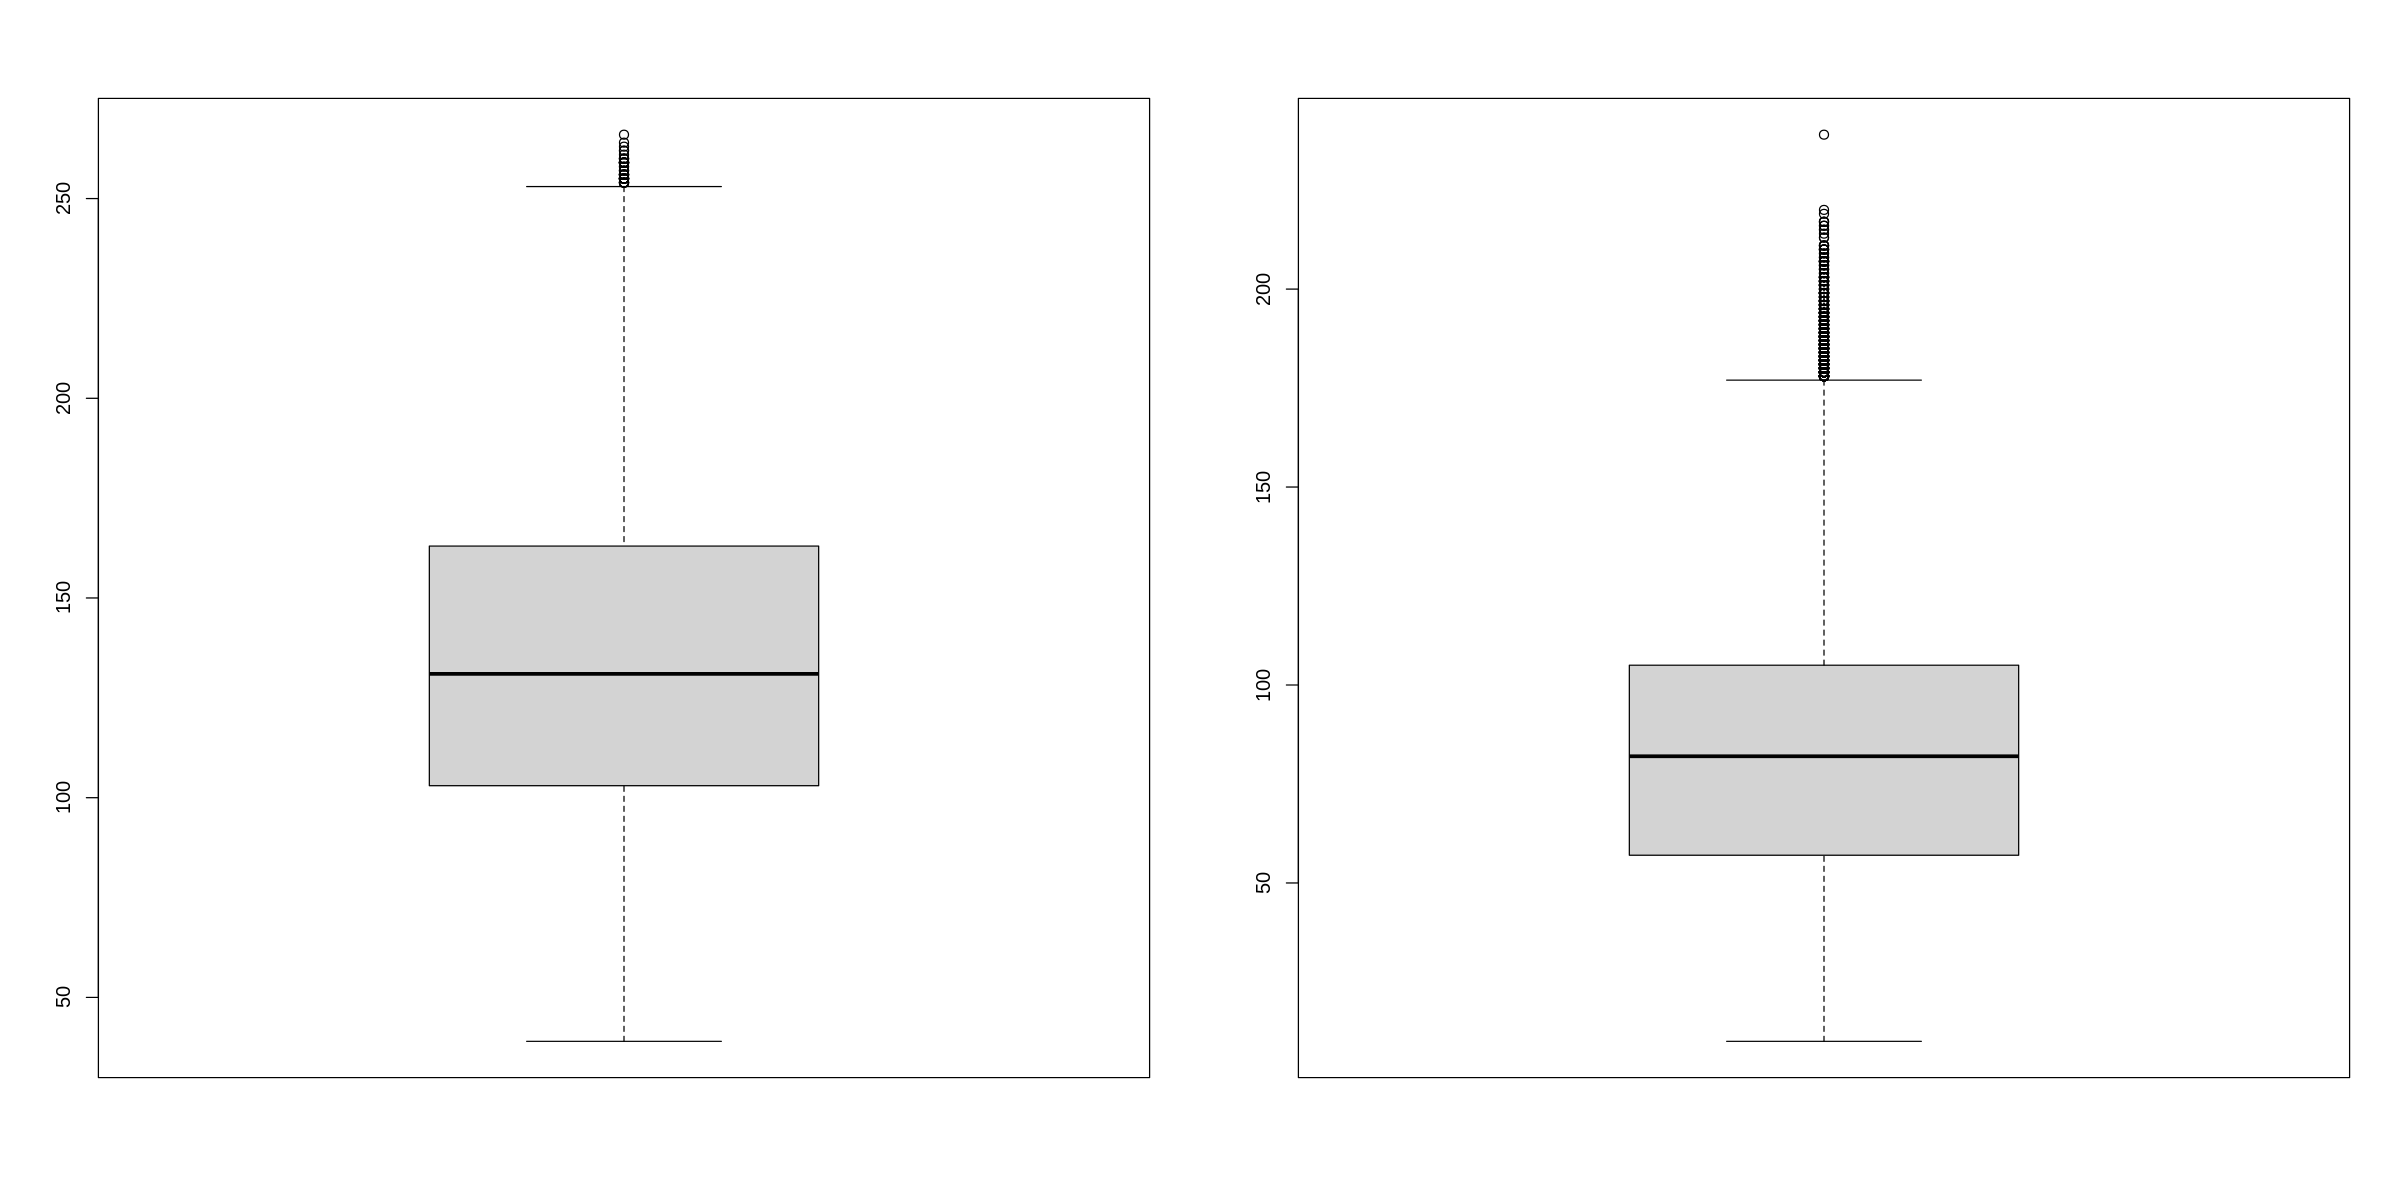

In [17]:
options(repr.plot.width = 20, repr.plot.height = 10)
par(mfrow=c(1,2))
p1 <- boxplot(colSums(Mslot >= 1))
p2 <- boxplot(colSums(Hslot >= 1))
# cowplot::plot_grid(p1, p2, ncol=2) 


The "ward" method has been renamed to "ward.D"; note new "ward.D2"

The "ward" method has been renamed to "ward.D"; note new "ward.D2"

The "ward" method has been renamed to "ward.D"; note new "ward.D2"

The "ward" method has been renamed to "ward.D"; note new "ward.D2"



null device 
          1

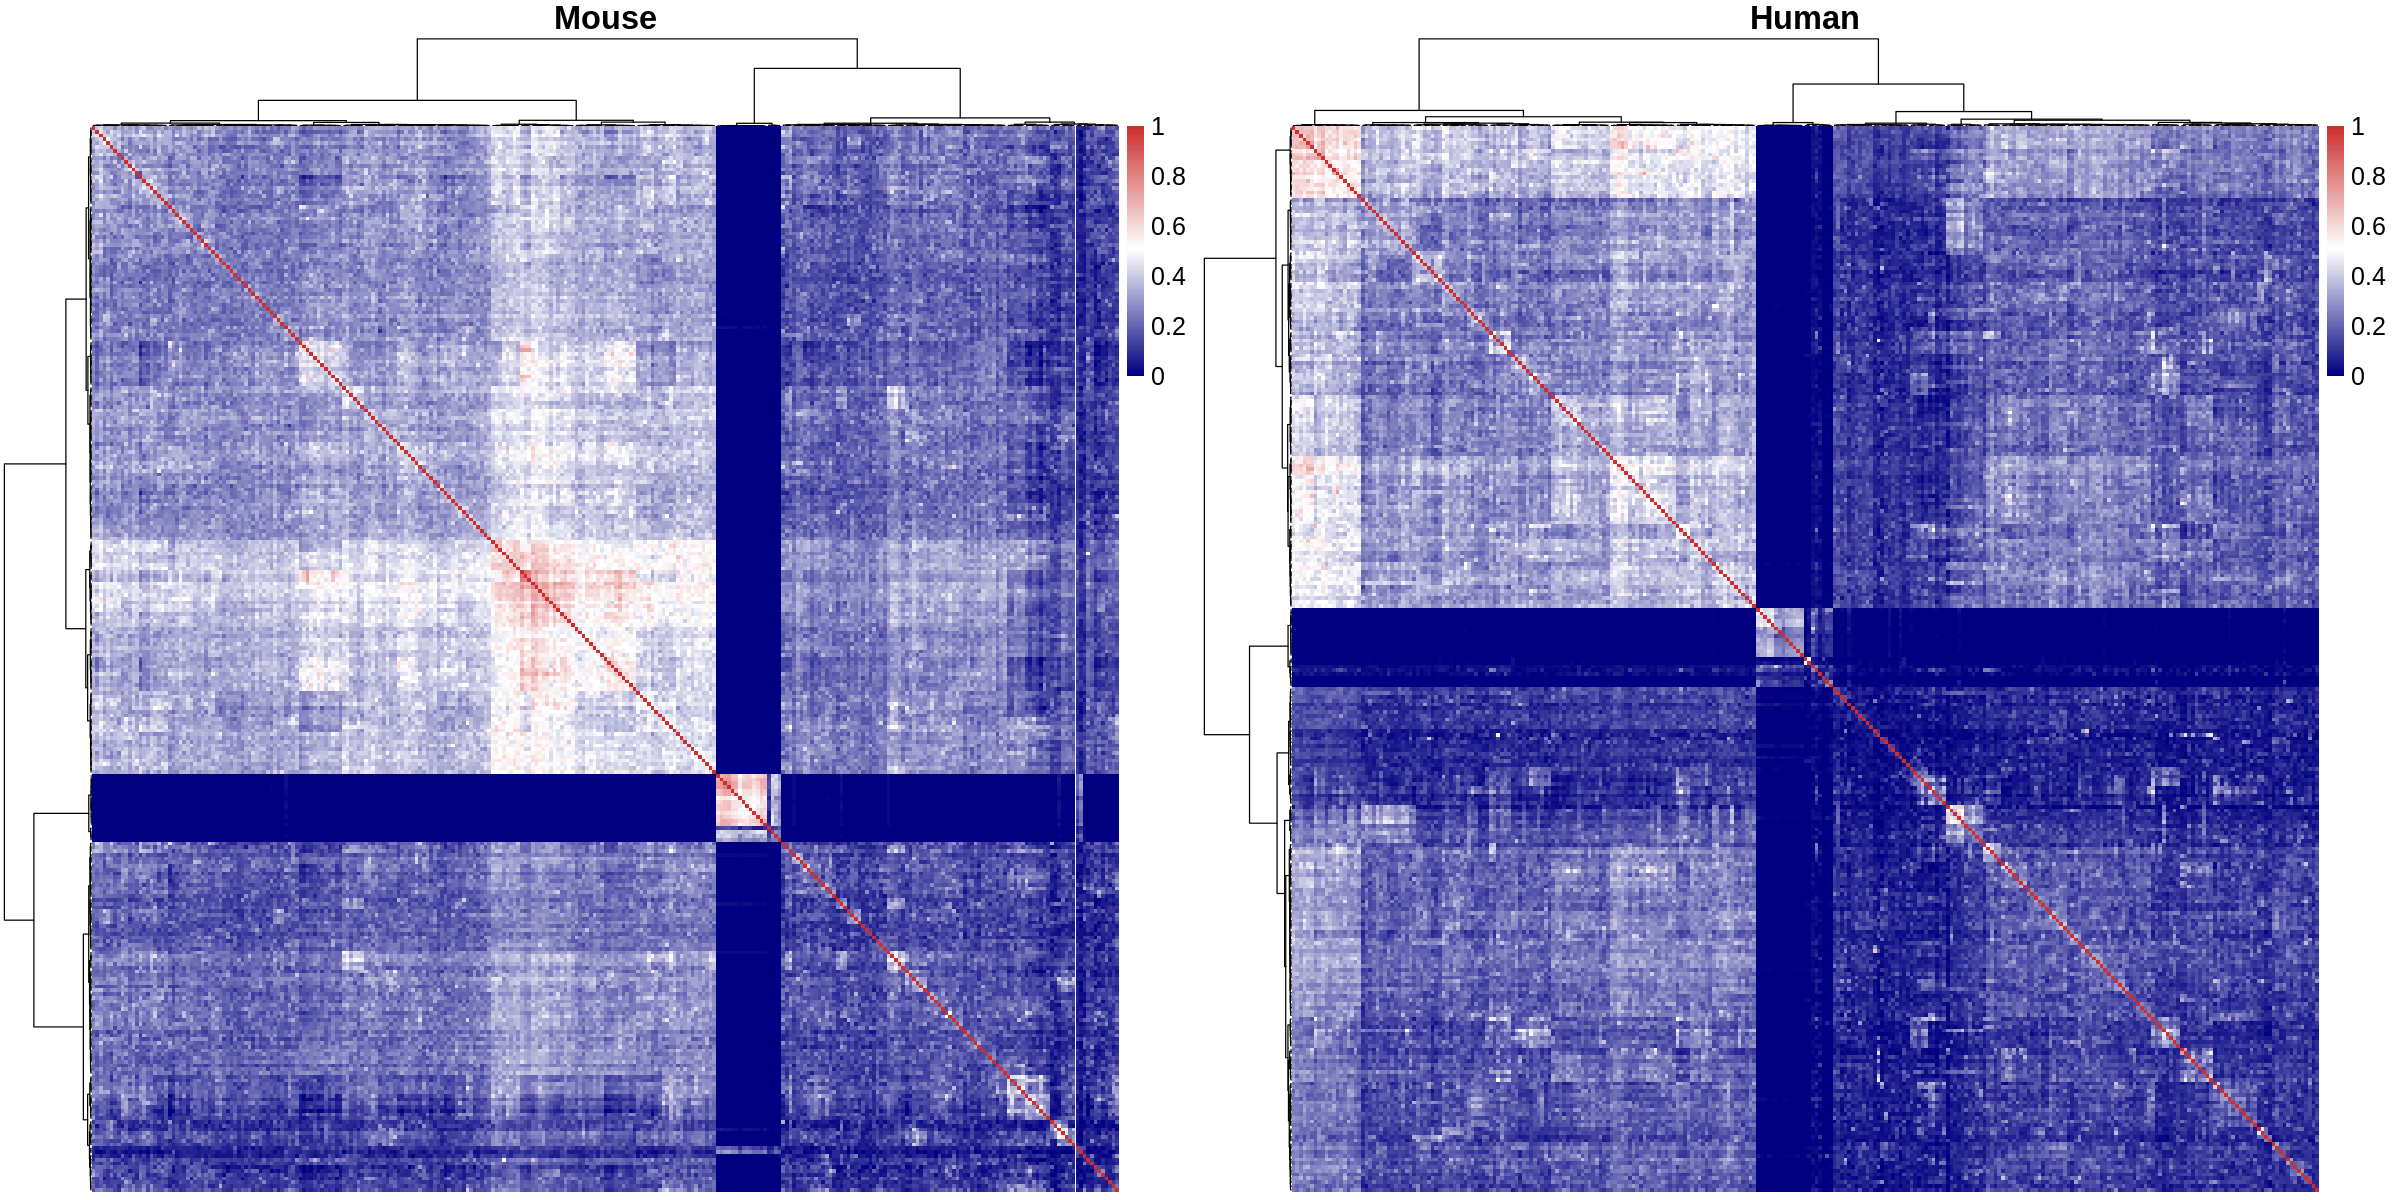

In [13]:
bk <- c(seq(0,1,by=0.01)) # seq(-1,0,by=0.01),
p1 <- pheatmap(mc, cluster_rows=TRUE, cluster_cols=TRUE, main="Mouse",     # color = rainbow(n, start=.7, end=.1), 
               color = c(colorRampPalette(colors = c("navy","white"))(length(bk)/2), colorRampPalette(colors = c("white","firebrick3"))(length(bk)/2)),
               breaks=bk, show_rownames=FALSE, show_colnames=FALSE, border_col=NA, fontsize=15, silent=TRUE, clustering_method='ward',
              )
p2 <- pheatmap(hc, cluster_rows=TRUE, cluster_cols=TRUE, main="Human", # color = colorRampPalette(c("navy", "white", "firebrick3"))(50),   # color = rainbow(n, start=.7, end=.1), 
               color = c(colorRampPalette(colors = c("navy","white"))(length(bk)/2), colorRampPalette(colors = c("white","firebrick3"))(length(bk)/2)),
               breaks=bk, show_rownames=FALSE, show_colnames=FALSE, border_col=NA, fontsize=15, silent=TRUE, clustering_method='ward',
              )

options(repr.plot.width = 20, repr.plot.height = 10)
cowplot::plot_grid(p1$gtable, p2$gtable, ncol=2) 
# colorbar 把低表达细胞去掉  
dev.off()


In [14]:
getModule <- function(mat){
    d = dist(mat, method = 'euclidean')
    tree = hclust(d, method = 'ward.D')
    v = cutree(tree, 3)[tree$order]
    gaps = which((v[-1] - v[-length(v)]) != 0)
    gene.cluster <- as.data.frame(v)
    gene.cluster$gene <- str_split(rownames(gene.cluster),'[.]',simplify = T)[,1]
    return(gene.cluster)
} 


In [15]:
Mmodule <- getModule(mc)
colnames(Mmodule) <- c('module_m', 'gene_m')
# rownames(Mmodule) <- c(1:nrow(Mmodule)) 
Mmodule$module_m <- paste0('M-', Mmodule$module_m)

Hmodule <- getModule(hc)
colnames(Hmodule) <- c('module_h', 'gene_h') 
Hmodule$module_h <- paste0('H-', Hmodule$module_h)

In [16]:
module_df <- Mmodule
module_df$upper_gene <- toupper(module_df$gene_m)
module_df$module_h <- Hmodule$module_h[match(module_df$upper_gene, Hmodule$gene_h)]

# module_df <- data.frame(table(module_df[,c('module_m','module_h')]))
# print(module_df)

In [17]:
module_df <- Mmodule
module_df$upper_gene <- toupper(module_df$gene_m)
module_df$module_h <- Hmodule$module_h[match(module_df$upper_gene, Hmodule$gene_h)]
# module_df$module_m <- paste0('M-', module_df$module_m)
# module_df$module_h <- paste0('H-', module_df$module_h)
module_ <- module_df

module_df <- module_df[grep('NA',module_df$module_h,invert=TRUE),]
module_df <- module_df[grep('NA',module_df$module_m,invert=TRUE),]
# module_df <- data.frame(table(module_df[,c('module_m','module_h')]))
# print(module_df)


In [18]:
module_df[which(module_df$module_h == 'H-2'), 'module_h'] = 'tmp'
module_df[which(module_df$module_h == 'H-1'), 'module_h'] = 'H-2'
module_df[which(module_df$module_h == 'tmp'), 'module_h'] = 'H-1'


In [19]:
Input <- list()
name <- c()
i =1 
for (item in unique(c(module_df$module_m, module_df$module_h))){
    name <- c(name, item)
    m <- c(module_df[which(module_df$module_m == item),'upper_gene'])
    h <- c(module_df[which(module_df$module_h == item),'upper_gene'])
    if(length(m)!=0) {Input[[i]] <- m}
    if(length(h)!=0) {Input[[i]] <- h} 
    i = i+1
}
names(Input) <- name 
Input <- Input[sapply(Input, function(x) !is.null(x))]

In [25]:
module_df['Bhlhe40',]

,module_m,gene_m,upper_gene,module_h
,<chr>,<chr>,<chr>,<chr>
Bhlhe40,M-1,Bhlhe40,BHLHE40,H-2


In [26]:
options(repr.plot.width = 10, repr.plot.height = 7)
upset(fromList(Input), order.by = "freq", text.scale = 3, nintersects=30,nsets = 20 )


ERROR: Error in upset(fromList(Input), order.by = "freq", text.scale = 3, nintersects = 30, : could not find function "upset"


In [20]:
annotate_m <- Mmodule
annotate_m <- subset(annotate_m, select=-gene_m)
annotate_m$module_m <- factor(annotate_m$module_m)


annotate_h <- Hmodule
annotate_h <- subset(annotate_h, select=-gene_h)
annotate_h$module_h <- factor(annotate_h$module_h)


The "ward" method has been renamed to "ward.D"; note new "ward.D2"

The "ward" method has been renamed to "ward.D"; note new "ward.D2"

The "ward" method has been renamed to "ward.D"; note new "ward.D2"

The "ward" method has been renamed to "ward.D"; note new "ward.D2"



null device 
          1

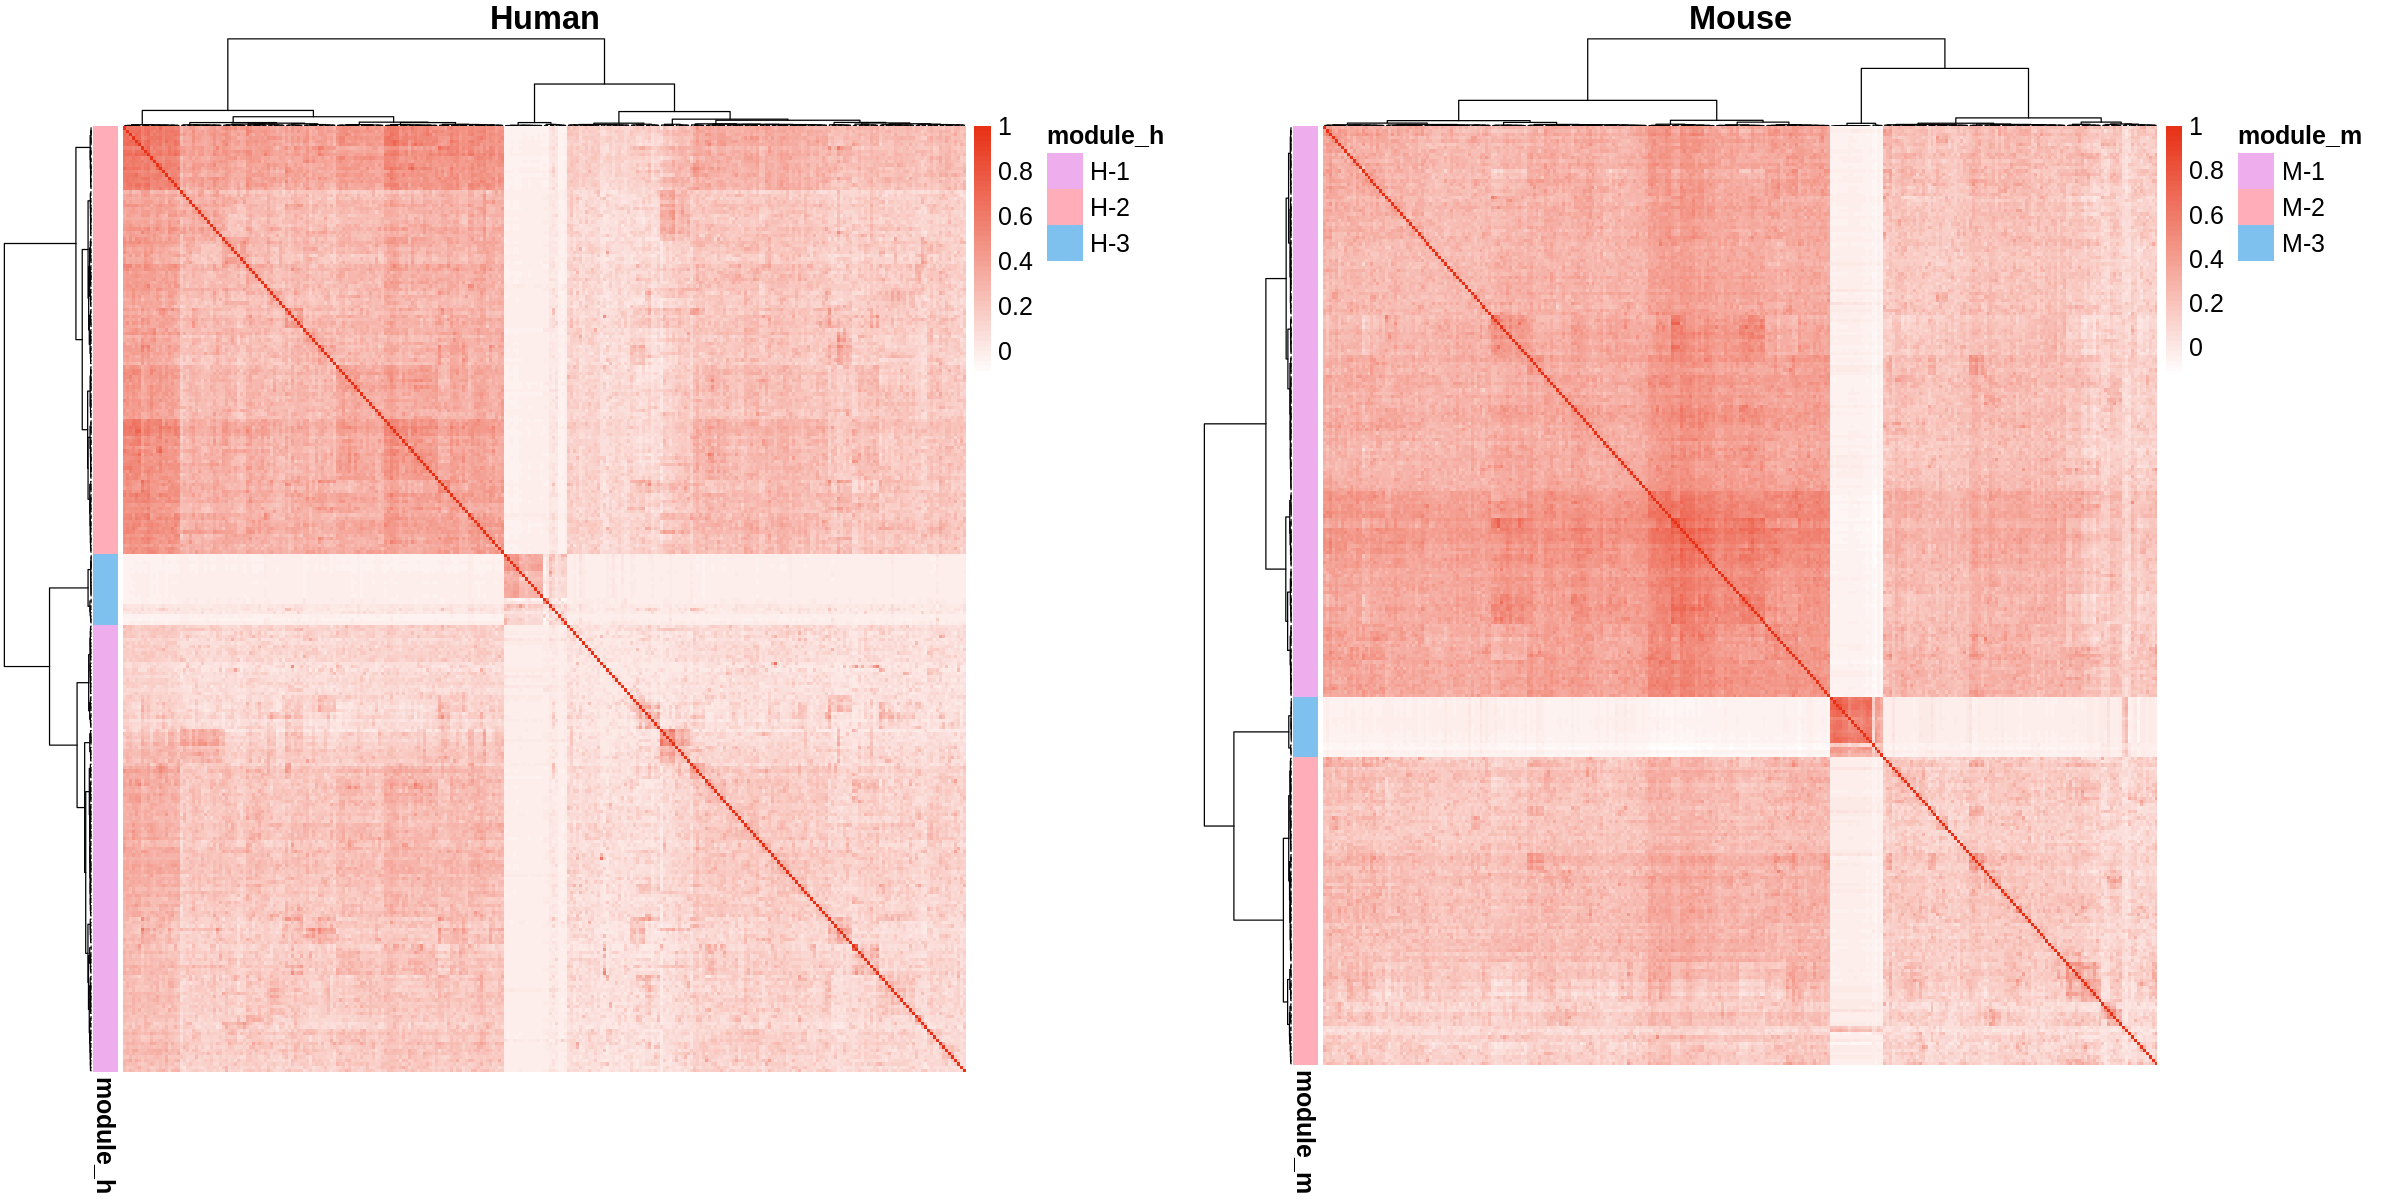

In [21]:

annotation_col_m = list(module_m = c(`M-1`='plum2', `M-2`="lightpink1", `M-3`="skyblue2"))
annotation_col_h = list(module_h = c(`H-1`='plum2', `H-2`="lightpink1", `H-3`="skyblue2"))

p1 <- pheatmap(mc, cluster_rows=TRUE, cluster_cols=TRUE, main="Mouse",  color = colorRampPalette(c("#ffffff", "#e83217"))(50),   # color = rainbow(n, start=.7, end=.1), 
         show_rownames=FALSE, show_colnames=FALSE, border_col=NA, fontsize=15, silent=TRUE, annotation_row = annotate_m, annotation_colors= annotation_col_m,clustering_method='ward',
              )
p2 <- pheatmap(hc, cluster_rows=TRUE, cluster_cols=TRUE, main="Human",  color = colorRampPalette(c("#ffffff", "#e83217"))(50),   # color = rainbow(n, start=.7, end=.1), 
         show_rownames=FALSE, show_colnames=FALSE, border_col=NA, fontsize=15, silent=TRUE,annotation_row = annotate_h, annotation_colors = annotation_col_h,clustering_method='ward',
              )

options(repr.plot.width = 20, repr.plot.height = 10)
cowplot::plot_grid(p2$gtable, p1$gtable, ncol=2) 
# colorbar 把低表达细胞去掉  
dev.off()


The "ward" method has been renamed to "ward.D"; note new "ward.D2"

The "ward" method has been renamed to "ward.D"; note new "ward.D2"

The "ward" method has been renamed to "ward.D"; note new "ward.D2"

The "ward" method has been renamed to "ward.D"; note new "ward.D2"



null device 
          1

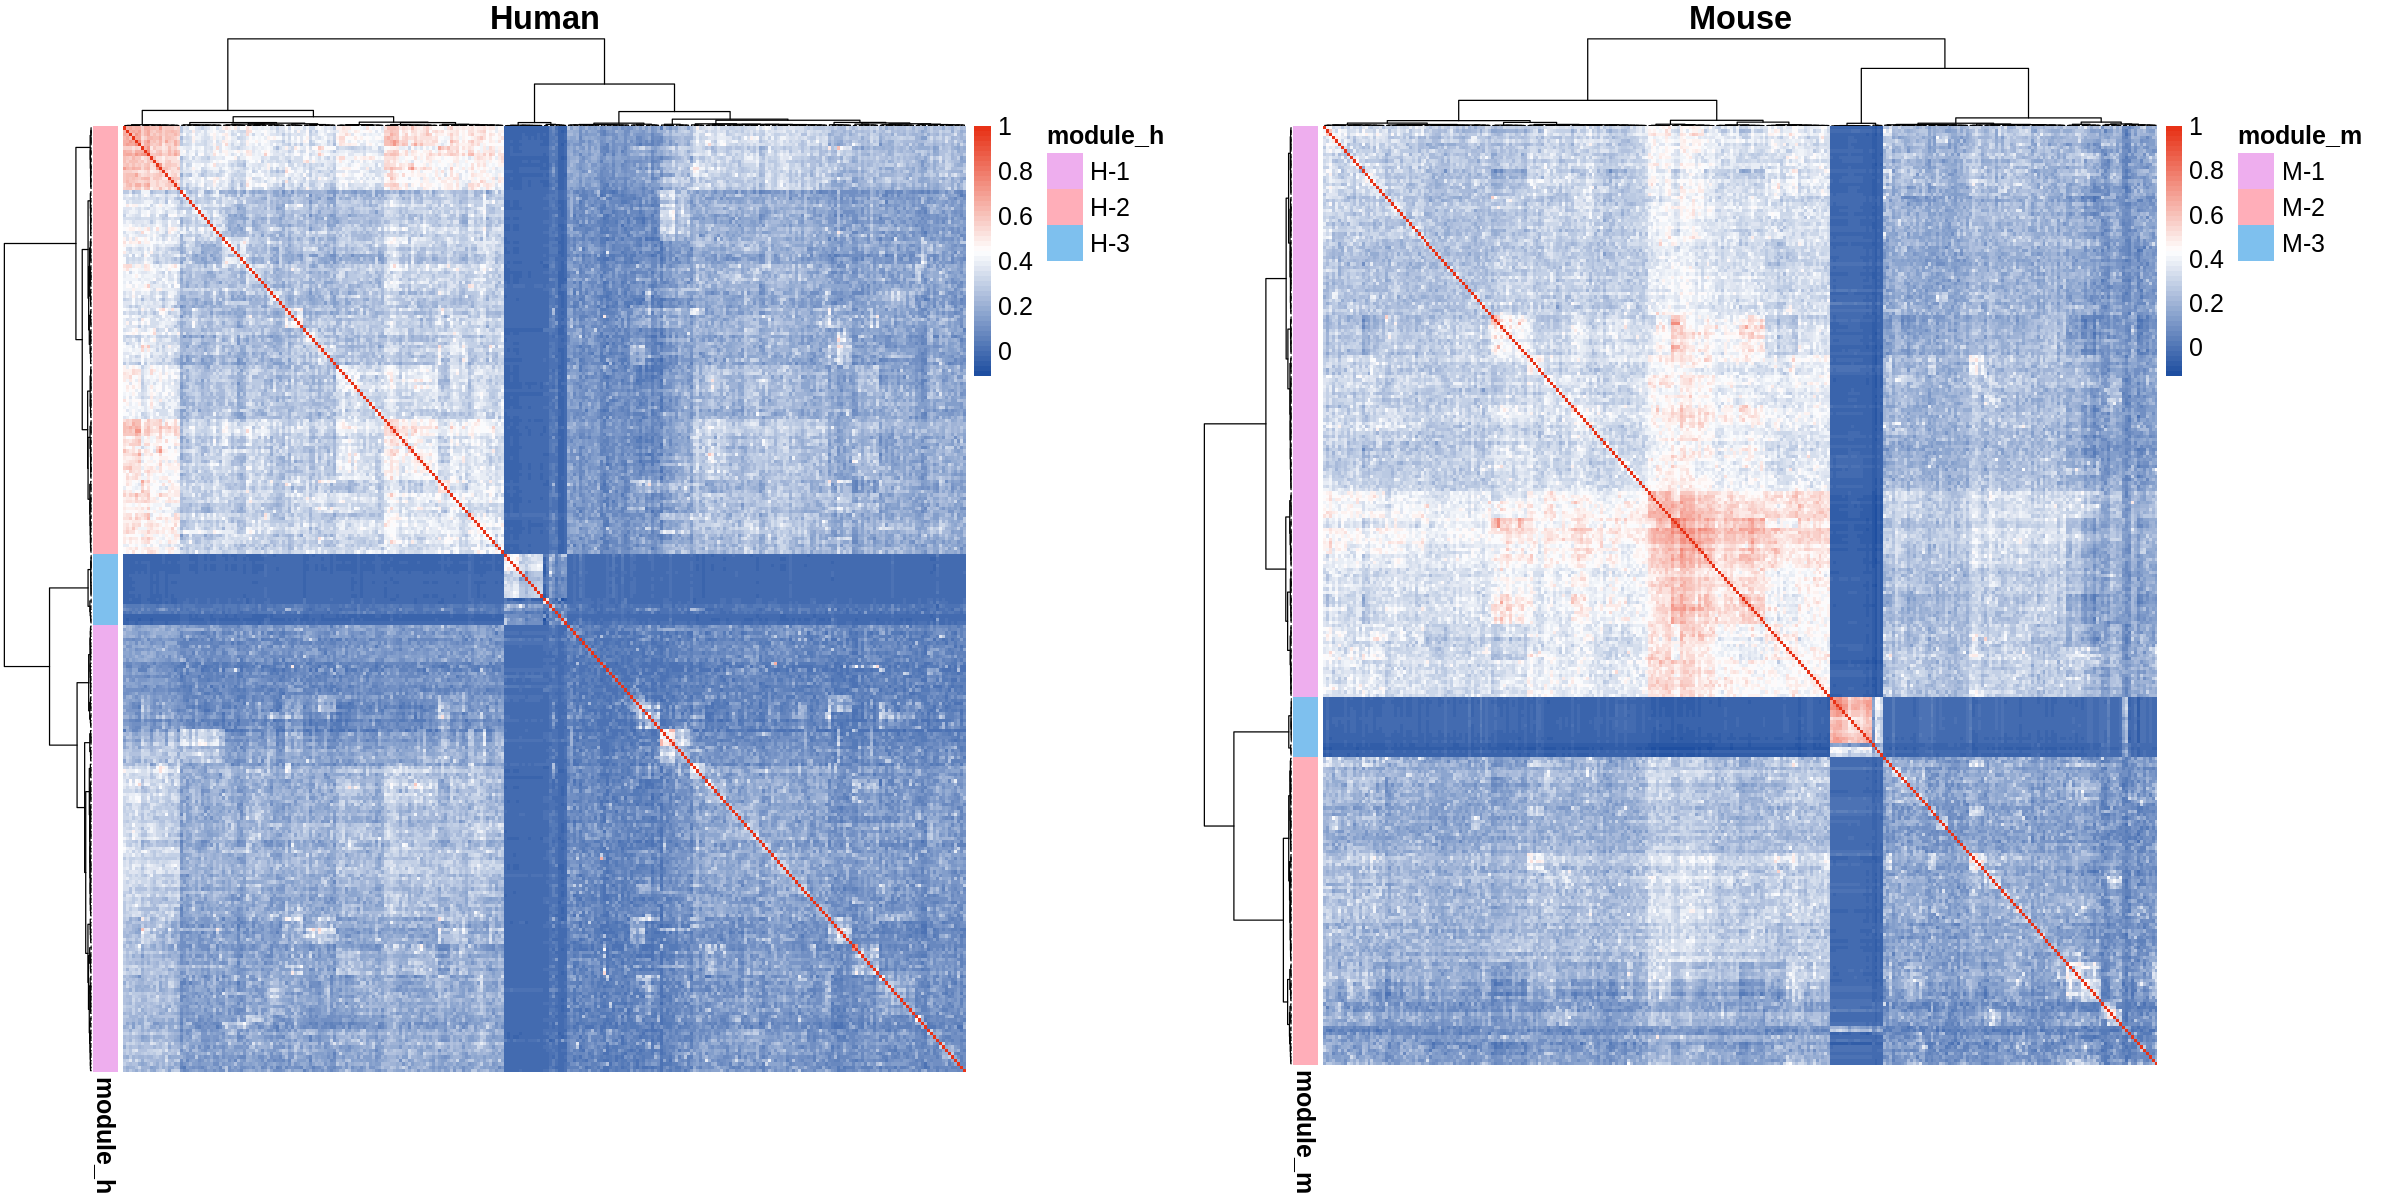

In [22]:

annotation_col_m = list(module_m = c(`M-1`='plum2', `M-2`="lightpink1", `M-3`="skyblue2"))
annotation_col_h = list(module_h = c(`H-1`='plum2', `H-2`="lightpink1", `H-3`="skyblue2"))

p1 <- pheatmap(mc, cluster_rows=TRUE, cluster_cols=TRUE, main="Mouse",  color = colorRampPalette(c("#1f4fa1", "white", "#e83217"))(50),   # color = rainbow(n, start=.7, end=.1), 
         show_rownames=FALSE, show_colnames=FALSE, border_col=NA, fontsize=15, silent=TRUE, annotation_row = annotate_m, annotation_colors= annotation_col_m,clustering_method='ward',
              )
p2 <- pheatmap(hc, cluster_rows=TRUE, cluster_cols=TRUE, main="Human",  color = colorRampPalette(c("#1f4fa1", "white", "#e83217"))(50),   # color = rainbow(n, start=.7, end=.1), 
         show_rownames=FALSE, show_colnames=FALSE, border_col=NA, fontsize=15, silent=TRUE,annotation_row = annotate_h, annotation_colors = annotation_col_h,clustering_method='ward',
              )

options(repr.plot.width = 20, repr.plot.height = 10)
cowplot::plot_grid(p2$gtable, p1$gtable, ncol=2) 
# colorbar 把低表达细胞去掉  
dev.off()


In [23]:
# 提取模块和基因信息
modules <- c('M-1', 'M-3', 'M-2')
human_modules <- c('H-1', 'H-3', 'H-2')  # 交换H2和H3的顺序

# 提取基因信息
genes_m <- unlist(lapply(seq_along(modules), function(i) {
  module_df[(module_df$module_m == modules[i]) & (module_df$module_h == human_modules[i]),] %>% drop_na() %>% pull(gene_m)
}))

genes_h <- unlist(lapply(seq_along(modules), function(i) {
  module_df[(module_df$module_m == modules[i]) & (module_df$module_h == human_modules[i]),] %>% drop_na() %>% pull(upper_gene)
}))

# 构建fmc和fhc矩阵
fmc <- mc[genes_m, genes_m]
fhc <- hc[genes_h, genes_h]

# 构建共享数据框
shared_df <- module_df[(module_df$module_m %in% modules) & (module_df$module_h %in% human_modules),] %>% drop_na()

null device 
          1

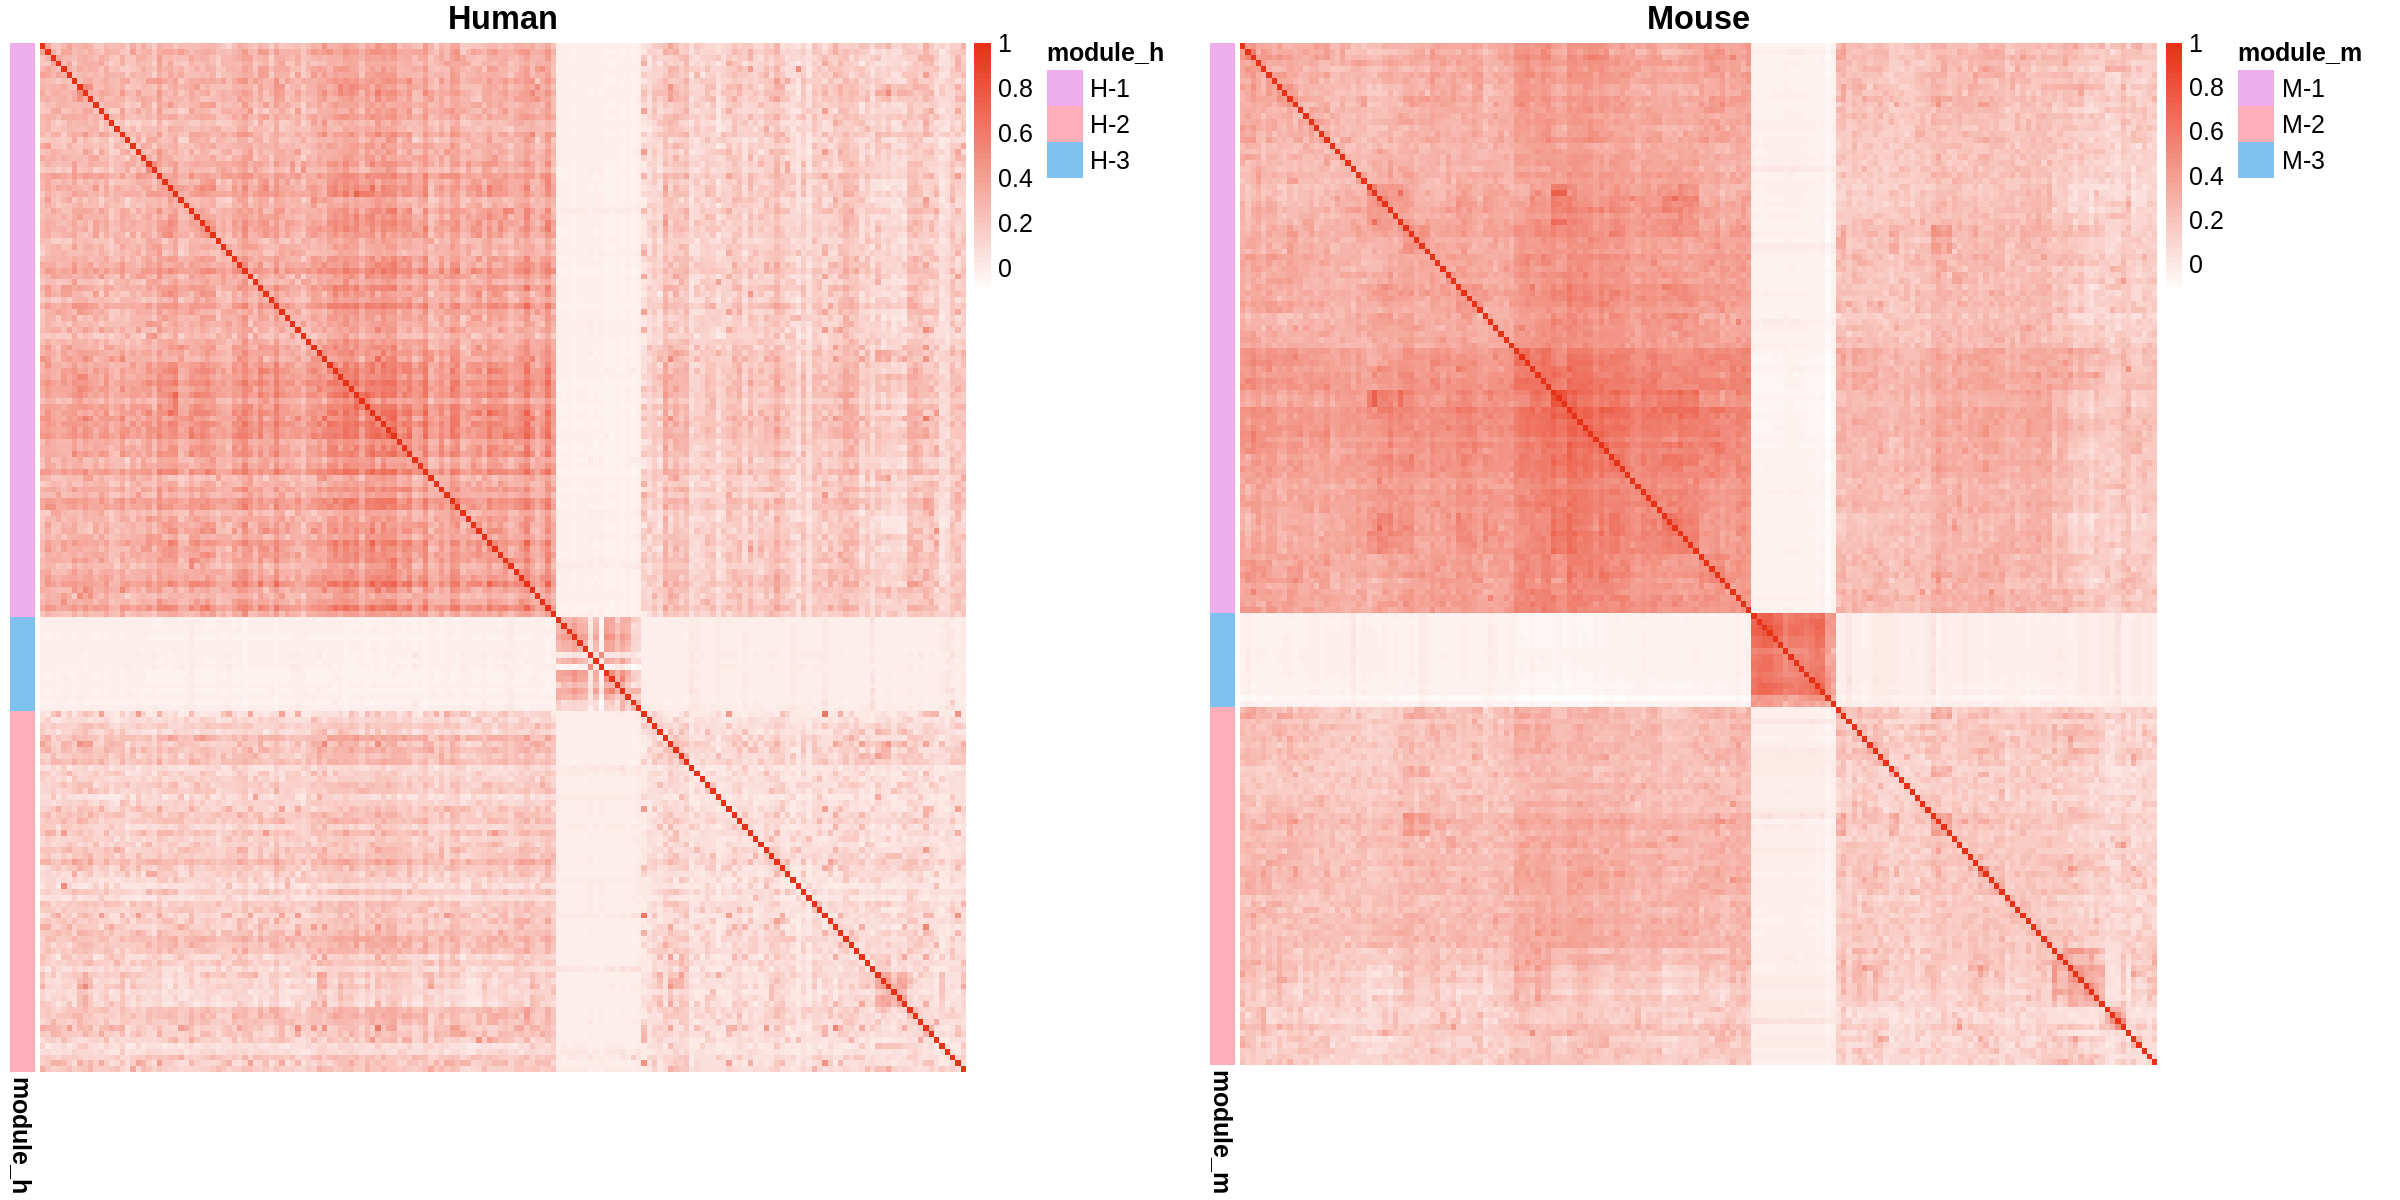

In [24]:
annotate_m <- shared_df %>% select(module_m)
annotate_h <- shared_df %>% select(module_h)
rownames(annotate_h) <- c(shared_df$upper_gene)

annotation_col_m = list(module_m = c(`M-1`='plum2', `M-2`="lightpink1", `M-3`="skyblue2"))
annotation_col_h = list(module_h = c(`H-1`='plum2', `H-2`="lightpink1", `H-3`="skyblue2"))

p1 <- pheatmap(fmc, cluster_rows=FALSE, cluster_cols=FALSE, main="Mouse",  color = colorRampPalette(c("#ffffff", "#e83217"))(50),   # color = rainbow(n, start=.7, end=.1), 
         show_rownames=FALSE, show_colnames=FALSE, border_col=NA, fontsize=15, silent=TRUE, annotation_row = annotate_m, annotation_colors= annotation_col_m,clustering_method='ward',
              )
p2 <- pheatmap(fhc, cluster_rows=FALSE, cluster_cols=FALSE, main="Human",  color = colorRampPalette(c("#ffffff", "#e83217"))(50),   # color = rainbow(n, start=.7, end=.1), 
         show_rownames=FALSE, show_colnames=FALSE, border_col=NA, fontsize=15, silent=TRUE,annotation_row = annotate_h, annotation_colors = annotation_col_h,clustering_method='ward',
              )

# options(repr.plot.width = 20, repr.plot.height = 10)
# pdf('./plots/heatmap_mouse_human.pdf', width=11, height=5)
cowplot::plot_grid(p2$gtable, p1$gtable, ncol=2) 
# colorbar 把低表达细胞去掉  
dev.off()


In [26]:
write.table(shared_df, 'shared_df.csv', sep='\t', quote=FALSE)

In [33]:
setwd('/home/wpy/stereoseq/20240702-Exclusive/')

In [ ]:
# annotate_m <- c(module_df[(module_df$module_m == 'M-1') & (module_df$module_h == 'H-1'),] %>% drop_na() %>% pull(gene_m), module_df[(module_df$module_m == 'M-2') & (module_df$module_h == 'H-2'),] %>% drop_na() %>% pull(gene_m), module_df[(module_df$module_m == 'M-3') & (module_df$module_h == 'H-3'),] %>% drop_na() %>% pull(gene_m))
annotation_col_m = list(module_m = c(`M-1`='plum2', `M-2`="lightpink1", `M-3`="skyblue2"))
p<-pheatmap(fmc, cluster_rows=TRUE, cluster_cols=TRUE, main="Mouse",  color = colorRampPalette(c("white", "#e83217"))(50),   # color = rainbow(n, start=.7, end=.1), 
         show_rownames=FALSE, show_colnames=FALSE, border_col=NA, fontsize=15, silent=TRUE, annotation_row = annotate_m, annotation_colors= annotation_col_m,clustering_method='ward')

pdf('./plots/heatmap_mouse.pdf', width=5.5, height=5)
grid::grid.newpage()
grid::grid.draw(p$gtable) 
dev.off()


The "ward" method has been renamed to "ward.D"; note new "ward.D2"

The "ward" method has been renamed to "ward.D"; note new "ward.D2"



ERROR: Error in annotation_row[rownames(mat), , drop = F]: incorrect number of dimensions


In [63]:
annotation_col_h = list(module_h = c(`H-1`='plum2', `H-2`="lightpink1", `H-3`="skyblue2"))
p<-pheatmap(fhc, cluster_rows=TRUE, cluster_cols=TRUE, main="Human",  color = colorRampPalette(c( "white", "#e83217"))(50),   # color = rainbow(n, start=.7, end=.1), 
         show_rownames=FALSE, show_colnames=FALSE, border_col=NA, fontsize=15, silent=TRUE,annotation_row = annotate_h, annotation_colors = annotation_col_h,clustering_method='ward')
pdf('./plots/heatmap_human.pdf', width=5.5, height=5)
grid::grid.newpage()
grid::grid.draw(p$gtable) 
dev.off()


The "ward" method has been renamed to "ward.D"; note new "ward.D2"

The "ward" method has been renamed to "ward.D"; note new "ward.D2"



png 
  2

In [40]:
1

[1] 1

In [79]:
m1 <- intersect(Input$`M-1`,Input$`H-1`)

In [80]:
m2 <- intersect(Input$`M-2`,Input$`H-2`)

In [81]:
m3 <-intersect(Input$`M-3`,Input$`H-3`) 

In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
library(clusterProfiler)

Warning message:
“package ‘clusterProfiler’ was built under R version 4.3.2”


clusterProfiler v4.10.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter




In [30]:
df <- read.csv('/home/wpy/stereoseq/20240702-Exclusive/module_df.csv')
m1 <- df[df$module_m == 'M-1', 'upper_gene']
m2 <- df[df$module_m == 'M-2', 'upper_gene']
m3 <- df[df$module_m == 'M-3', 'upper_gene']
m4 <- df[df$module_m == 'M-4', 'upper_gene']

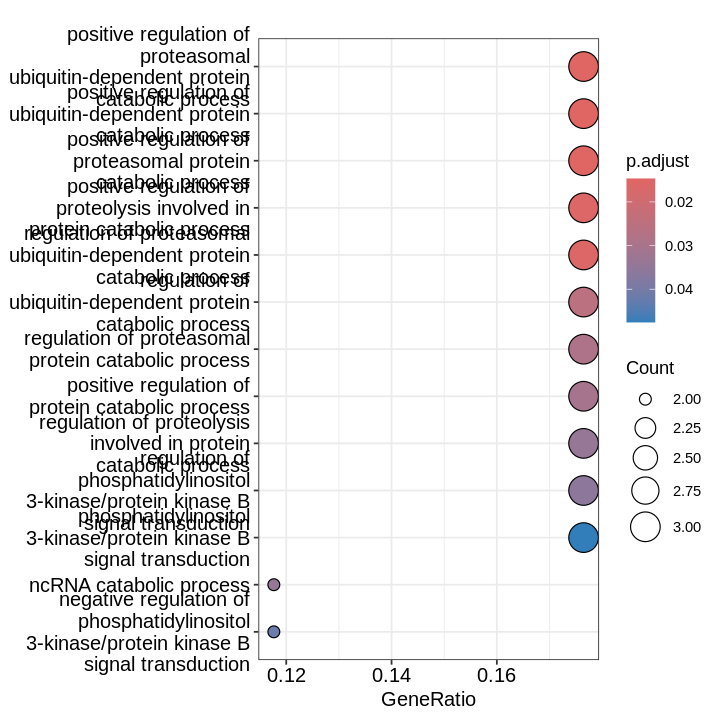

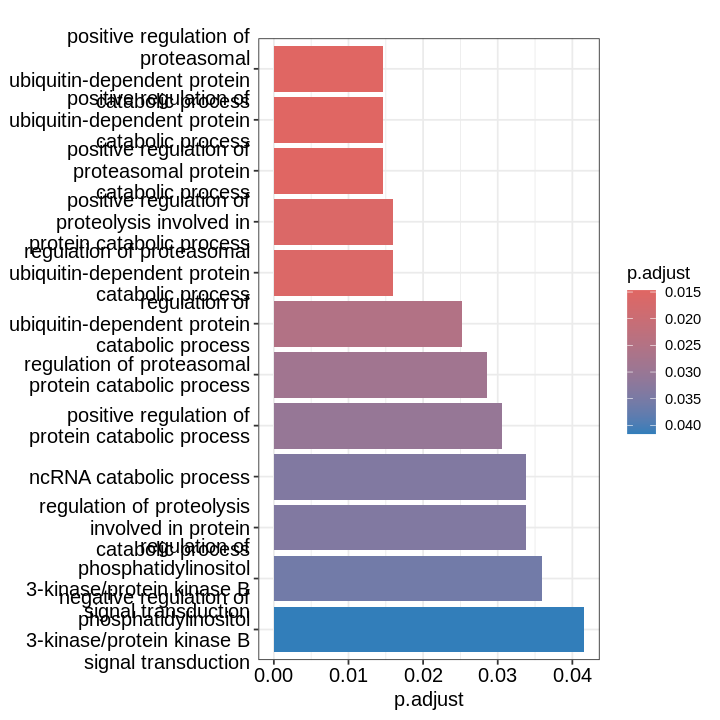

In [31]:
enrich.go <- enrichGO(gene = m1,
    OrgDb = "org.Hs.eg.db",
    keyType = 'SYMBOL',  #指定给定的基因名称类型，例如这里以 entrze id 为例
    ont = 'BP',  #GO Ontology，可选 BP、MF、CC，也可以指定 ALL 同时计算 3 者
    maxGSSize = 300,
    pAdjustMethod = 'fdr',  #指定 p 值校正方法
    pvalueCutoff = 0.05,  #指定 p 值阈值（可指定 1 以输出全部）
    qvalueCutoff = 0.05,  #指定 q 值阈值（可指定 1 以输出全部）
    readable = FALSE)

options(repr.plot.width=6,repr.plot.height=6)
# barplot(enrich.go, showCategory = 10)

pdf("/home/zhaoyp/collaboration/haorui/res/enrichGO_module1.pdf", width = 6, height = 6)  
dotplot(enrich.go, showCategory =15)
dev.off()  

pdf("/home/zhaoyp/collaboration/haorui/res/enrichGO_bar_module1.pdf", width = 6, height = 6) 
barplot(enrich.go,x = "p.adjust",showCategory =12)
dev.off() 

m1 <- head(as.data.frame(enrich.go), 10)


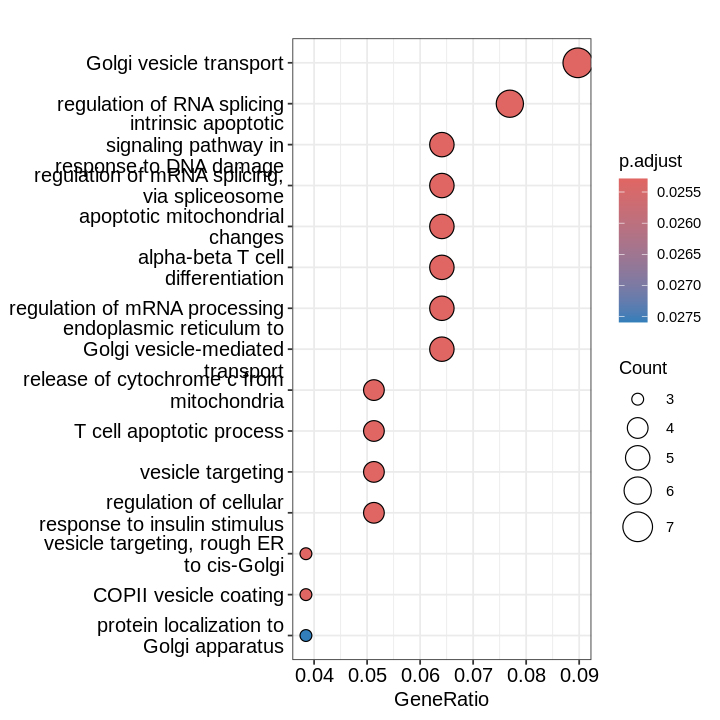

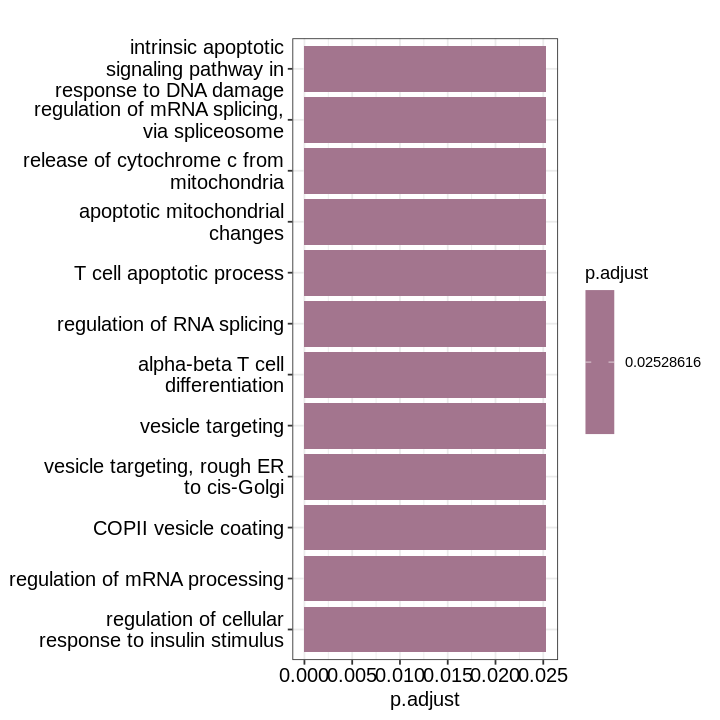

In [27]:
enrich.go <- enrichGO(gene = m2,
    OrgDb = "org.Hs.eg.db",
    keyType = 'SYMBOL',  #指定给定的基因名称类型，例如这里以 entrze id 为例
    ont = 'BP',  #GO Ontology，可选 BP、MF、CC，也可以指定 ALL 同时计算 3 者
    maxGSSize = 300,
    pAdjustMethod = 'fdr',  #指定 p 值校正方法
    pvalueCutoff = 0.05,  #指定 p 值阈值（可指定 1 以输出全部）
    qvalueCutoff = 0.05,  #指定 q 值阈值（可指定 1 以输出全部）
    readable = FALSE)

options(repr.plot.width=6,repr.plot.height=6)
barplot(enrich.go, showCategory = 10)

pdf("/home/zhaoyp/collaboration/haorui/res/enrichGO_module1.pdf", width = 6, height = 6)  
dotplot(enrich.go, showCategory =15)
# dev.off()  

pdf("/home/zhaoyp/collaboration/haorui/res/enrichGO_bar_module1.pdf", width = 6, height = 6) 
barplot(enrich.go,x = "p.adjust",showCategory =12)
# dev.off() 

m1 <- head(as.data.frame(enrich.go), 10)


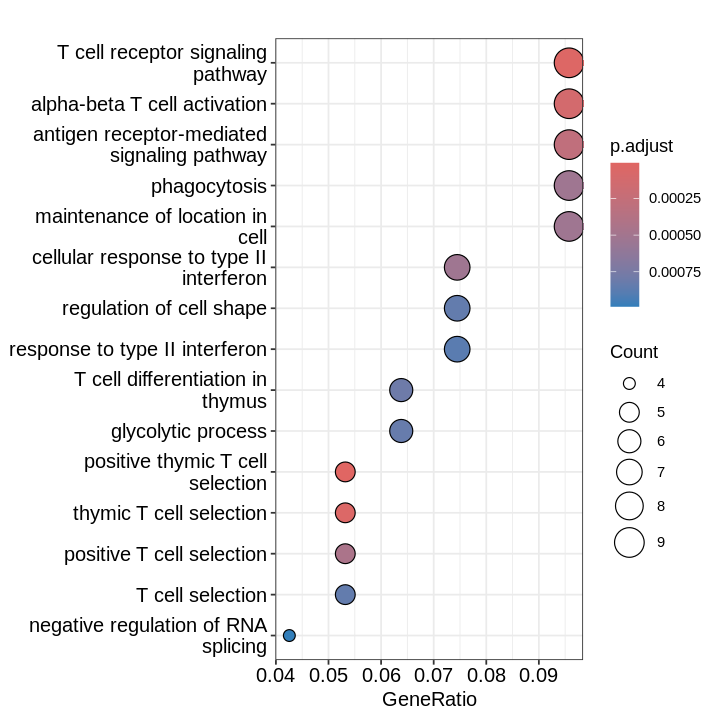

In [28]:
enrich.go <- enrichGO(gene = m3,
    OrgDb = "org.Hs.eg.db",
    keyType = 'SYMBOL',  #指定给定的基因名称类型，例如这里以 entrze id 为例
    ont = 'BP',  #GO Ontology，可选 BP、MF、CC，也可以指定 ALL 同时计算 3 者
    maxGSSize = 300,
    pAdjustMethod = 'fdr',  #指定 p 值校正方法
    pvalueCutoff = 0.05,  #指定 p 值阈值（可指定 1 以输出全部）
    qvalueCutoff = 0.05,  #指定 q 值阈值（可指定 1 以输出全部）
    readable = FALSE)



options(repr.plot.width=6,repr.plot.height=6)
barplot(enrich.go, showCategory = 10)
pdf("/home/zhaoyp/collaboration/haorui/res/enrichGO_module2.pdf", width = 6, height = 6)  
dotplot(enrich.go, showCategory =15)
dev.off() 

m2 <- head(as.data.frame(enrich.go), 12)


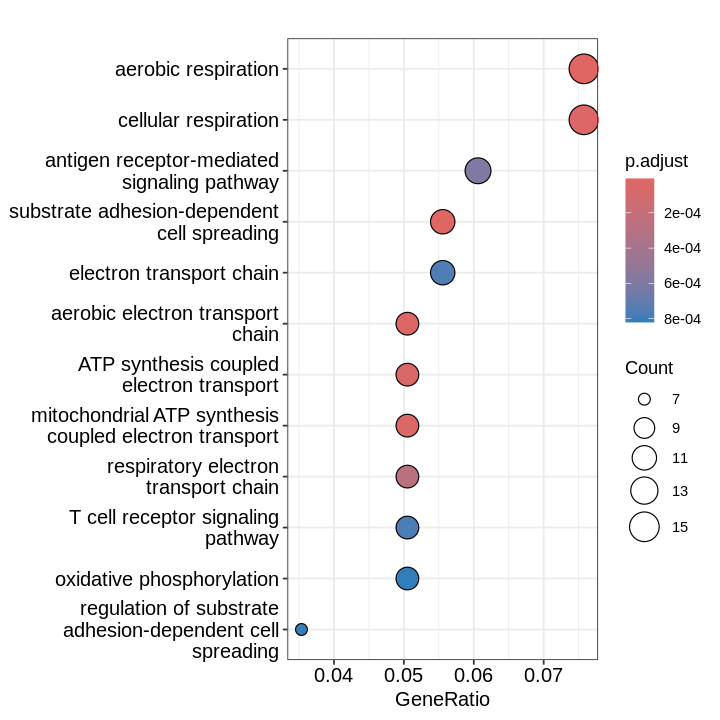

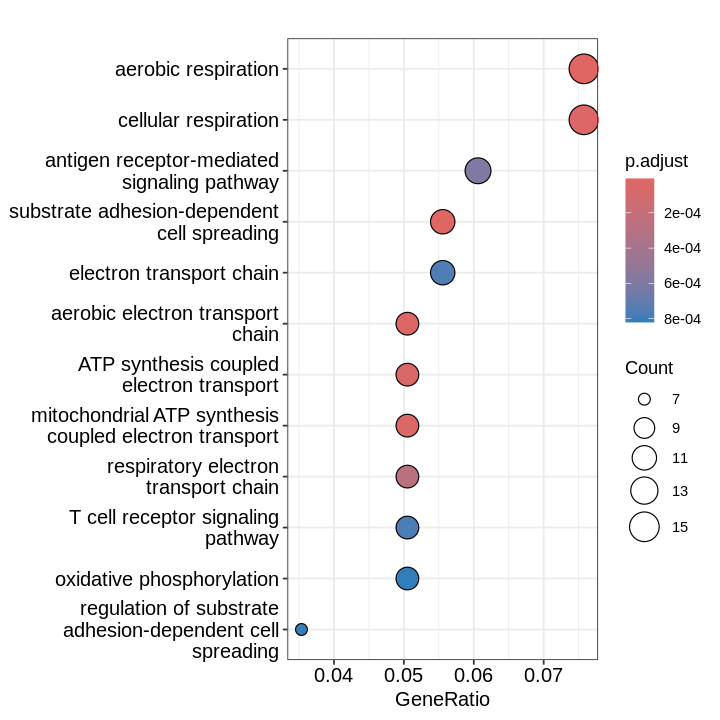

In [29]:
enrich.go <- enrichGO(gene = m4,
    OrgDb = "org.Hs.eg.db",
    keyType = 'SYMBOL',  #指定给定的基因名称类型，例如这里以 entrze id 为例
    ont = 'BP',  #GO Ontology，可选 BP、MF、CC，也可以指定 ALL 同时计算 3 者
    maxGSSize = 300,
    pAdjustMethod = 'fdr',  #指定 p 值校正方法
    pvalueCutoff = 0.05,  #指定 p 值阈值（可指定 1 以输出全部）
    qvalueCutoff = 0.05,  #指定 q 值阈值（可指定 1 以输出全部）
    readable = FALSE)

options(repr.plot.width=6,repr.plot.height=6)
barplot(enrich.go, showCategory = 10)
pdf("/home/zhaoyp/collaboration/haorui/res/enrichGO_module3.pdf", width = 6, height = 6) 
dotplot(enrich.go,x = "GeneRatio", showCategory =12)
# dev.off() 

pdf("/home/zhaoyp/collaboration/haorui/res/enrichGO_dot1_module3.pdf", width = 6, height = 6) 
dotplot(enrich.go, showCategory =12)
dev.off() 

m3 <- head(as.data.frame(enrich.go), 12)


In [75]:
m1$module='Module1'
m2$module='Module2'
m3$module='Module3'

merged_df <- rbind(m1, m2, m3)  # all = TRUE 表示全外连接  


In [85]:
head(merged_df) 


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,module
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
GO:0045619,GO:0045619,regulation of lymphocyte differentiation,10/92,210/18903,7.542661e-08,5.245765e-05,4.226358e-05,RHOH/LAG3/CD27/SASH3/IKZF3/ID2/TOX/IL2RG/JAK3/CD2,10,Module1
GO:0002228,GO:0002228,natural killer cell mediated immunity,7/92,77/18903,9.353771e-08,5.245765e-05,4.226358e-05,SH2D1A/CD96/LAG3/KLRK1/NKG7/KLRD1/CD2,7,Module1
GO:1903039,GO:1903039,positive regulation of leukocyte cell-cell adhesion,11/92,275/18903,9.590064e-08,5.245765e-05,4.226358e-05,ITGA4/RHOH/PYCARD/CD27/SASH3/KLRK1/IL2RG/LCK/ITGB2/JAK3/CCL5,11,Module1
GO:0001909,GO:0001909,leukocyte mediated cytotoxicity,8/92,134/18903,2.917350e-07,1.151860e-04,9.280197e-05,SH2D1A/CTSC/PRF1/LAG3/KLRK1/NKG7/KLRD1/CD2,8,Module1
GO:0001906,GO:0001906,cell killing,9/92,189/18903,3.509629e-07,1.151860e-04,9.280197e-05,SH2D1A/CTSC/PRF1/LAG3/KLRK1/GAPDH/NKG7/KLRD1/CD2,9,Module1
GO:0070229,GO:0070229,negative regulation of lymphocyte apoptotic process,5/92,37/18903,9.430627e-07,2.579276e-04,2.078047e-04,TSC22D3/CD27/JAK3/PDCD1/CCL5,5,Module1


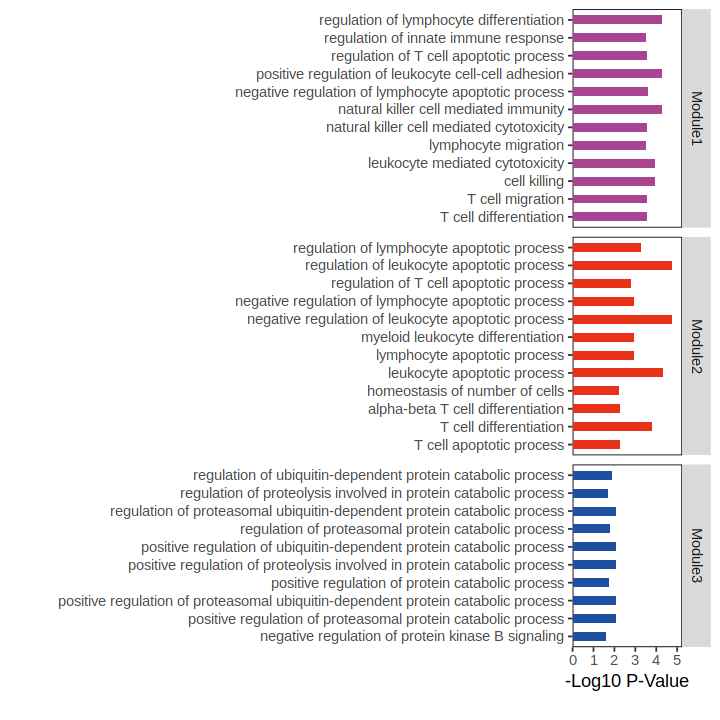

In [90]:
ggplot(merged_df, aes(Description, -log10(p.adjust))) +
 geom_col(aes(fill = module), width = 0.5, show.legend = FALSE) +
 scale_fill_manual(values = c('#a84491', '#e83217', '#1f4fa1')) +
 facet_grid(module~., scale = 'free_y', space = 'free_y') +
 theme(panel.grid = element_blank(), panel.background = element_rect(color = 'black', fill = 'transparent')) +
 scale_y_continuous(expand = expansion(mult = c(0, 0.1))) + 
 coord_flip() +
 labs(x = '', y = '-Log10 P-Value\n')

ggsave('/home/zhaoyp/collaboration/haorui/res/module_go.pdf', width=6,height=5.5)


In [66]:
m1

[1] "SLC44A2"  "CCND2"    "YWHAQ"    "SLA2"     "DUSP2"    "GPR171"  
 [7] "SH2D1A"   "TSC22D3"  "TXNIP"    "KLF6"     "ITGA4"    "DOK2"    
[13] "RHOH"     "DCAF7"    "OGDH"     "GIMAP5"   "PYCARD"   "CD2BP2"  
[19] "UQCR10"   "MAP4"     "CTSC"     "NDUFA11"  "CD96"     "PTPN7"   
[25] "PRF1"     "TPI1"     "LAG3"     "SAMSN1"   "S100A4"   "ANXA5"   
[31] "PGAM1"    "CD27"     "CBLB"     "MYO1G"    "WNK1"     "HMGB2"   
[37] "ARHGAP9"  "SASH3"    "IKZF3"    "LPXN"     "PSTPIP1"  "ID2"     
[43] "TNFRSF1B" "ECH1"     "KLRK1"    "RGS1"     "TOX"      "CALM3"   
[49] "GNG5"     "ILK"      "SURF4"    "SLA"      "LIMD2"    "GIMAP4"  
[55] "CTSW"     "SRGN"     "NPM1"     "IL2RG"    "LCK"      "GAPDH"   
[61] "PKM"      "ALDOA"    "NKG7"     "MYL12A"   "LSP1"     "CLIC1"   
[67] "SH3BGRL3" "ANXA6"    "CTSD"     "ITGB2"    "SH2D2A"   "IL2RB"   
[73] "PTPRCAP"  "LIME1"    "CD82"     "JAK3"     "CTSB"     "PSMB9"   
[79] "TAP1"     "COX5A"    "CXCR6"    "PDCD1"    "TIGIT"    "S100A11" 
[85] "CST7"     "KLRD1"    "FKBP1A"   "HCST"     "CRIP1"    "LASP1"   
[91] "ITGAL"    "CCL5"     "GIMAP7"   "TNFAIP3"  "COTL1"    "CD2"     
[97] "LCP2"

In [67]:
m2

[1] "CDKN2D"   "BCL2"     "SPTBN1"   "GPR183"   "ACP5"     "FOS"     
 [7] "FBL"      "FOXP1"    "BCL11B"   "ZBTB7A"   "ODC1"     "TNIP1"   
[13] "FLOT1"    "NAA50"    "SSBP4"    "CAPNS1"   "SERTAD1"  "GRAP2"   
[19] "XIST"     "S1PR4"    "PPP1R16B" "SLBP"     "STARD3NL" "ZBP1"    
[25] "TLE3"     "YPEL5"    "SMAP2"    "GRAMD1A"  "RNF187"   "NR4A1"   
[31] "TUBB4B"   "FKBP4"    "NDUFC1"   "BCL2L11"  "YBX1"     "ELOVL1"  
[37] "SMS"      "TOMM5"    "PRDX3"    "VTI1B"    "KDELR2"   "SOCS3"   
[43] "ADD3"     "SOCS1"    "TCF7"     "S1PR1"    "IL7R"     "SATB1"   
[49] "SELL"     "CCR7"     "RGS10"    "HOPX"     "PET100"   "ISG15"   
[55] "IRF7"     "CCL4"     "RASGRP2"  "CCDC85B"  "CD7"      "DUSP10"  
[61] "JUN"

In [68]:
m3

[1] "SELENOK"  "SELENOW"  "SEM1"     "ELOB"     "RTRAF"    "SELENOF" 
 [7] "TRBC2"    "COPS9"    "TRAC"     "TRIR"     "NOP53"    "ARHGAP45"
[13] "RACK1"    "JPT1"     "SARAF"    "ADGRE5"

# UMAP

In [36]:
Matlas = readRDS('/home/zhaoyp/collaboration/haorui/ref_TILAtlas_mouse_v1.rds')
Hatlas = readRDS('/home/zhaoyp/collaboration/haorui/0.NatMed_Tatlas_lh/CD8.rds')


In [42]:
Hatlas <- AddModuleScore(
  object = Hatlas,
  features = list(c('SLC44A2', 'CCND2', 'YWHAQ', 'SLA2', 'DUSP2', 'GPR171', 'SH2D1A', 'TSC22D3', 'TXNIP', 'KLF6', 'ITGA4', 'DOK2', 'RHOH', 'DCAF7', 'OGDH', 'GIMAP5', 'PYCARD', 'CD2BP2', 'UQCR10', 'MAP4', 'CTSC', 'NDUFA11', 'CD96', 'PTPN7', 'PRF1', 'TPI1', 'LAG3', 'SAMSN1', 'S100A4', 'ANXA5', 'PGAM1', 'CD27', 'CBLB', 'MYO1G', 'WNK1', 'HMGB2', 'ARHGAP9', 'SASH3', 'IKZF3', 'LPXN', 'PSTPIP1', 'ID2', 'TNFRSF1B', 'ECH1', 'KLRK1', 'RGS1', 'TOX', 'CALM3', 'GNG5', 'ILK', 'SURF4', 'SLA', 'LIMD2', 'GIMAP4', 'CTSW', 'SRGN', 'NPM1', 'IL2RG', 'LCK', 'GAPDH', 'PKM', 'ALDOA', 'NKG7', 'MYL12A', 'LSP1', 'CLIC1', 'SH3BGRL3', 'ANXA6', 'CTSD', 'ITGB2', 'SH2D2A', 'IL2RB', 'PTPRCAP', 'LIME1', 'CD82', 'JAK3', 'CTSB', 'PSMB9', 'TAP1', 'COX5A', 'CXCR6', 'PDCD1', 'TIGIT', 'S100A11', 'CST7', 'KLRD1', 'FKBP1A', 'HCST', 'CRIP1', 'LASP1', 'ITGAL', 'CCL5', 'GIMAP7', 'TNFAIP3', 'COTL1', 'CD2', 'LCP2')),
  name = "module1"
)

Hatlas <- AddModuleScore(
  object = Hatlas,
  features = list(c('CDKN2D', 'BCL2', 'SPTBN1', 'GPR183', 'ACP5', 'FOS', 'FBL', 'FOXP1', 'BCL11B', 'ZBTB7A', 'ODC1', 'TNIP1', 'FLOT1', 'NAA50', 'SSBP4', 'CAPNS1', 'SERTAD1', 'GRAP2', 'XIST', 'S1PR4', 'PPP1R16B', 'SLBP', 'STARD3NL', 'ZBP1', 'TLE3', 'YPEL5', 'SMAP2', 'GRAMD1A', 'RNF187', 'NR4A1', 'TUBB4B', 'FKBP4', 'NDUFC1', 'BCL2L11', 'YBX1', 'ELOVL1', 'SMS', 'TOMM5', 'PRDX3', 'VTI1B', 'KDELR2', 'SOCS3', 'ADD3', 'SOCS1', 'TCF7', 'S1PR1', 'IL7R', 'SATB1', 'SELL', 'CCR7', 'RGS10', 'HOPX', 'PET100', 'ISG15', 'IRF7', 'CCL4', 'RASGRP2', 'CCDC85B', 'CD7', 'DUSP10', 'JUN')),
  name = "module2"
)

Hatlas <- AddModuleScore(
  object = Hatlas,
  features = list(c('SELENOK', 'SELENOW', 'SEM1', 'ELOB', 'RTRAF', 'SELENOF', 'TRBC2', 'COPS9', 'TRAC', 'TRIR', 'NOP53', 'ARHGAP45', 'RACK1', 'JPT1', 'SARAF', 'ADGRE5')),
  name = "module3"
)

In [46]:
Hatlas@meta.data

,cell.type,TissueType,CancerType,batch,module11,module21,module31,module1
,<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ACCAGAGTTATTAATG_Cell1,CD8_c3_Tn,Primary tumor tissue,AML,batch_level1_1,0.2184793,-0.012043703,0.51027117,0.51027117
ATTCCAGATGGCATCG_Cell2,CD8_c3_Tn,Primary tumor tissue,AML,batch_level1_1,0.3268426,-0.140296880,0.47403068,0.47403068
AAGACTAGACCGCTAC_Cell3,CD8_c3_Tn,Primary tumor tissue,AML,batch_level1_1,0.1825884,-0.134286301,-0.12383174,-0.12383174
CGCTGTAAAGTGAAAA_Cell4,CD8_c3_Tn,Primary tumor tissue,AML,batch_level1_1,0.2888784,-0.076012737,0.07126182,0.07126182
TGCATCGTTCCTGGGT_Cell5,CD8_c3_Tn,Primary tumor tissue,AML,batch_level1_1,0.1956993,-0.035657500,0.52139939,0.52139939
CGGAAGTTAAAAGTAG_Cell6,CD8_c3_Tn,Primary tumor tissue,AML,batch_level1_1,0.4040396,-0.047251410,0.60880713,0.60880713
TATTCGACCTAGGCTT_Cell7,CD8_c0_t-Teff,Primary tumor tissue,AML,batch_level1_1,0.3246819,-0.051387168,0.47105646,0.47105646
TATTGCCAGATGAATT_Cell8,CD8_c3_Tn,Primary tumor tissue,AML,batch_level1_1,0.1929986,-0.140128240,0.41895509,0.41895509
CCAGCAAACCAAGGAG_Cell9,CD8_c3_Tn,Primary tumor tissue,AML,batch_level1_1,0.3584567,-0.171268044,0.08882449,0.08882449


In [49]:
options(repr.plot.width=9, repr.plot.height=6) 
Idents(Hatlas) = 'cell.type'
hatlas_plot <- DimPlot(Hatlas, reduction='umap') 

ggsave("/home/zhaoyp/collaboration/haorui/res/celltype.pdf", plot = hatlas_plot, width = 9, height = 8)


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



In [50]:
options(repr.plot.width=9, repr.plot.height=8) 
feature_plot <- FeaturePlot(Hatlas, features = c("module11", 'module21', 'module31'), min.cutoff = 0) 

ggsave("/home/zhaoyp/collaboration/haorui/res/module_feature.pdf", plot = feature_plot, width = 9, height = 8)


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



# Prepare for scenic


In [2]:
# Matlas = readRDS('/home/zhaoyp/collaboration/haorui/ref_TILAtlas_mouse_v1.rds')
Hatlas = readRDS('/home/zhaoyp/collaboration/haorui/0.NatMed_Tatlas_lh/CD8.rds')


In [3]:
# 计算每个细胞的基因数目 (nFeature_RNA)
nFeature_RNA <- colSums(Hatlas@assays$RNA@counts > 0)

# 将 nFeature_RNA 作为元数据添加到 Seurat 对象中
Hatlas <- AddMetaData(Hatlas, metadata = nFeature_RNA, col.name = "nFeature_RNA")


In [4]:
Hatlas


An object of class Seurat 
70777 features across 110218 samples within 1 assay 
Active assay: RNA (70777 features, 0 variable features)
 2 layers present: counts, data
 1 dimensional reduction calculated: umap

In [5]:
Hatlas <- subset(Hatlas, subset = nFeature_RNA > 200 )
Hatlas

An object of class Seurat 
70777 features across 110187 samples within 1 assay 
Active assay: RNA (70777 features, 0 variable features)
 2 layers present: counts, data
 1 dimensional reduction calculated: umap

In [6]:
# 1. 计算每个基因的表达细胞数目
gene_expression_cell_count <- rowSums(Hatlas@assays$RNA@counts > 0)

# 2. 设置过滤的阈值，比如在至少 10 个细胞中有表达
min_cells <- 110218 * 0.01
genes_to_keep <- names(gene_expression_cell_count[gene_expression_cell_count >= min_cells])

# 3. 使用 `subset()` 函数去除不符合条件的基因
Hatlas <- subset(Hatlas, features = genes_to_keep)

Hatlas


An object of class Seurat 
11847 features across 110187 samples within 1 assay 
Active assay: RNA (11847 features, 0 variable features)
 2 layers present: counts, data
 1 dimensional reduction calculated: umap

In [7]:
# 原来的数据太大了
# sce = GetAssayData(Hatlas[["RNA"]], slot = "data") 
# write.csv(sce, file="/home/zhaoyp/collaboration/haorui/scenic/sce.csv")


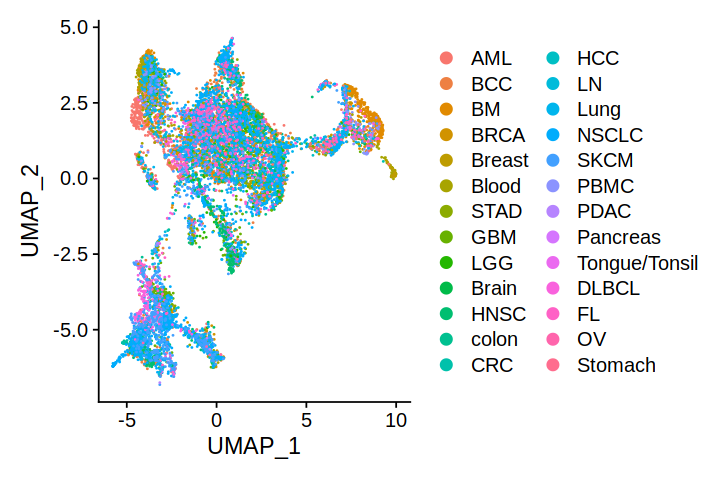

In [14]:
options(repr.plot.width=6, repr.plot.height=4) 

set.seed(42)  # 设置随机种子，确保可重复性

sample_ratio <- 0.1
num_cells <- floor(ncol(Hatlas) * sample_ratio)

sample_cells <- sample(colnames(Hatlas), num_cells) 
Hatlas_sampled <- subset(Hatlas, cells = sample_cells)

DimPlot(Hatlas_sampled, reduction = "umap")


In [15]:
Hatlas_sampled

An object of class Seurat 
11847 features across 11018 samples within 1 assay 
Active assay: RNA (11847 features, 0 variable features)
 2 layers present: counts, data
 1 dimensional reduction calculated: umap

In [16]:
sce = GetAssayData(Hatlas_sampled[["RNA"]], slot = "data") 
write.csv(sce, file="/home/zhaoyp/collaboration/haorui/scenic/sce_subsampled.csv") 


Warning message:
"The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
i Please use the `layer` argument instead."


## SCENIC result interprate

In [18]:
Hatlas = readRDS('/home/zhaoyp/collaboration/haorui/0.NatMed_Tatlas_lh/CD8.rds')

nFeature_RNA <- colSums(Hatlas@assays$RNA@counts > 0) 
Hatlas <- AddMetaData(Hatlas, metadata = nFeature_RNA, col.name = "nFeature_RNA")

Hatlas <- subset(Hatlas, subset = nFeature_RNA > 200 ) 
Hatlas


An object of class Seurat 
70777 features across 110187 samples within 1 assay 
Active assay: RNA (70777 features, 0 variable features)
 2 layers present: counts, data
 1 dimensional reduction calculated: umap

In [22]:
Hatlas <- AddModuleScore(
  object = Hatlas,
  features = list(c('SLC44A2', 'CCND2', 'YWHAQ', 'SLA2', 'DUSP2', 'GPR171', 'SH2D1A', 'TSC22D3', 'TXNIP', 'KLF6', 'ITGA4', 'DOK2', 'RHOH', 'DCAF7', 'OGDH', 'GIMAP5', 'PYCARD', 'CD2BP2', 'UQCR10', 'MAP4', 'CTSC', 'NDUFA11', 'CD96', 'PTPN7', 'PRF1', 'TPI1', 'LAG3', 'SAMSN1', 'S100A4', 'ANXA5', 'PGAM1', 'CD27', 'CBLB', 'MYO1G', 'WNK1', 'HMGB2', 'ARHGAP9', 'SASH3', 'IKZF3', 'LPXN', 'PSTPIP1', 'ID2', 'TNFRSF1B', 'ECH1', 'KLRK1', 'RGS1', 'TOX', 'CALM3', 'GNG5', 'ILK', 'SURF4', 'SLA', 'LIMD2', 'GIMAP4', 'CTSW', 'SRGN', 'NPM1', 'IL2RG', 'LCK', 'GAPDH', 'PKM', 'ALDOA', 'NKG7', 'MYL12A', 'LSP1', 'CLIC1', 'SH3BGRL3', 'ANXA6', 'CTSD', 'ITGB2', 'SH2D2A', 'IL2RB', 'PTPRCAP', 'LIME1', 'CD82', 'JAK3', 'CTSB', 'PSMB9', 'TAP1', 'COX5A', 'CXCR6', 'PDCD1', 'TIGIT', 'S100A11', 'CST7', 'KLRD1', 'FKBP1A', 'HCST', 'CRIP1', 'LASP1', 'ITGAL', 'CCL5', 'GIMAP7', 'TNFAIP3', 'COTL1', 'CD2', 'LCP2')),
  name = "module1"
)

Hatlas <- AddModuleScore(
  object = Hatlas,
  features = list(c('CDKN2D', 'BCL2', 'SPTBN1', 'GPR183', 'ACP5', 'FOS', 'FBL', 'FOXP1', 'BCL11B', 'ZBTB7A', 'ODC1', 'TNIP1', 'FLOT1', 'NAA50', 'SSBP4', 'CAPNS1', 'SERTAD1', 'GRAP2', 'XIST', 'S1PR4', 'PPP1R16B', 'SLBP', 'STARD3NL', 'ZBP1', 'TLE3', 'YPEL5', 'SMAP2', 'GRAMD1A', 'RNF187', 'NR4A1', 'TUBB4B', 'FKBP4', 'NDUFC1', 'BCL2L11', 'YBX1', 'ELOVL1', 'SMS', 'TOMM5', 'PRDX3', 'VTI1B', 'KDELR2', 'SOCS3', 'ADD3', 'SOCS1', 'TCF7', 'S1PR1', 'IL7R', 'SATB1', 'SELL', 'CCR7', 'RGS10', 'HOPX', 'PET100', 'ISG15', 'IRF7', 'CCL4', 'RASGRP2', 'CCDC85B', 'CD7', 'DUSP10', 'JUN')),
  name = "module2"
)

Hatlas <- AddModuleScore(
  object = Hatlas,
  features = list(c('SELENOK', 'SELENOW', 'SEM1', 'ELOB', 'RTRAF', 'SELENOF', 'TRBC2', 'COPS9', 'TRAC', 'TRIR', 'NOP53', 'ARHGAP45', 'RACK1', 'JPT1', 'SARAF', 'ADGRE5')),
  name = "module3"
)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



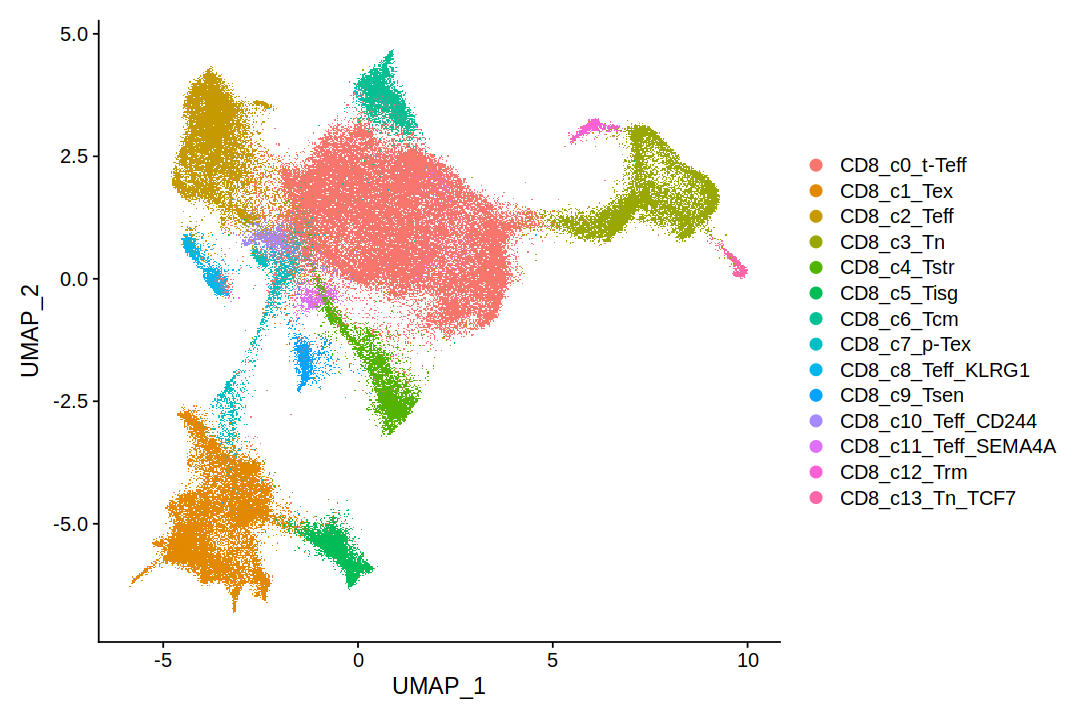

In [23]:
options(repr.plot.width=9, repr.plot.height=6) 
Idents(Hatlas) = 'cell.type'
DimPlot(Hatlas, reduction='umap') 


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



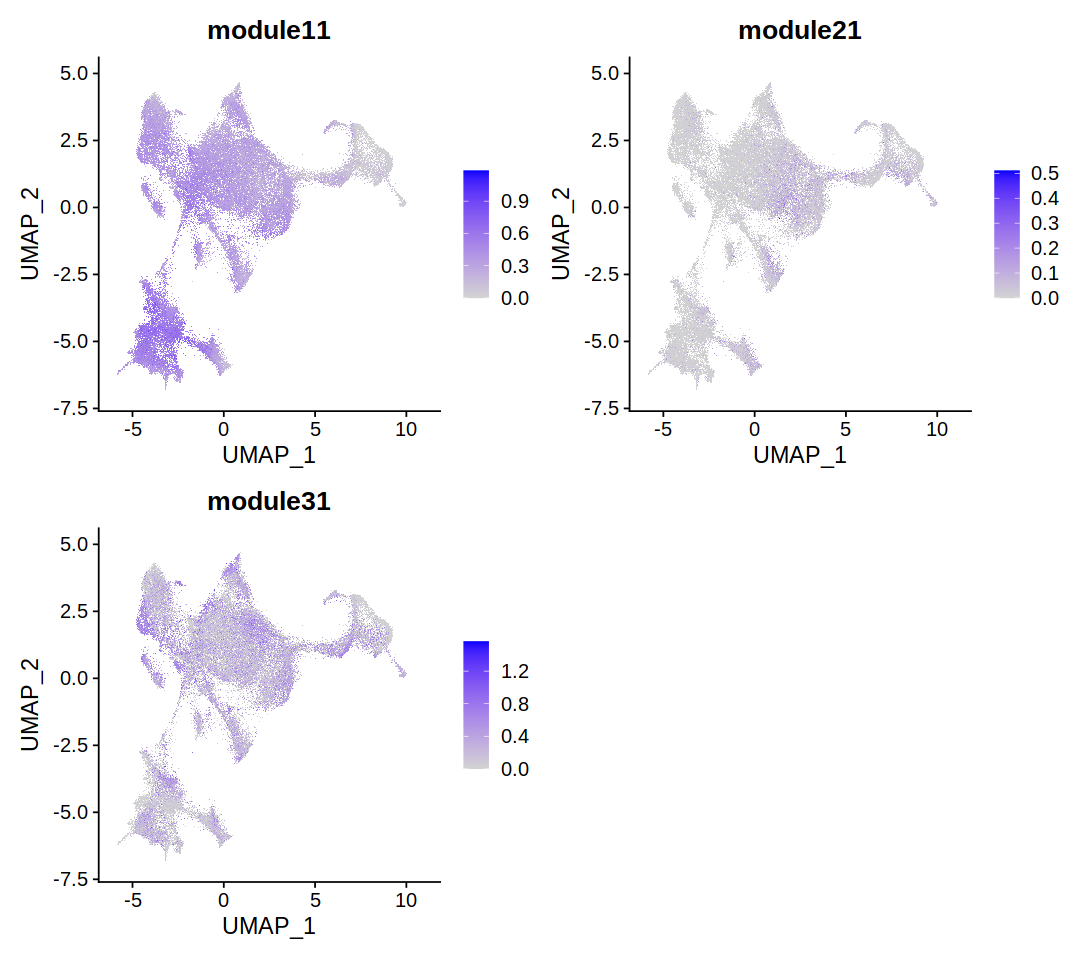

In [24]:
options(repr.plot.width=9, repr.plot.height=8) 
FeaturePlot(Hatlas, features = c("module11", 'module21', 'module31'), min.cutoff = 0) 


In [29]:
length(intersect(colnames(sce_regulon_AUC), colnames(Hatlas)))

[1] 11018

In [30]:
dim(sce_regulon_AUC)

[1]   211 11019

In [21]:
sce_regulon_AUC = read.csv('/home/zhaoyp/collaboration/haorui/scenic/sce_regulon_AUC.csv')
head(sce_regulon_AUC)


,Regulon,ACCAGAGTTATTAATG_Cell1,CAGACGAATATGCCTC_Cell16,AAACCTCGCGAACATC_Cell26,CAAATAAGTAGCTAAT_Cell27,CATTCCACTTGGATCT_Cell32,GATGGTTACCTGACGG_Cell36,GTTAGTGGGGGGCAAG_Cell40,CCCGAGTTTTAAGGGA_Cell49,TGTTTTACGGCAGTCG_Cell57,...,TAACTAGCCTGTGCGC_Cell110100,GGCTCGGTTCCAAGCG_Cell110103,CGGATACTTTCTCCAC_Cell110106,CGATGACTCCAGACTA_Cell110119,GGGGATAAGTCGCACG_Cell110151,TTAGCCCTCTTACCGG_Cell110173,AAAGACTGACGGCCCG_Cell110184,GTCTATTGGTCCTGAG_Cell110193,TAAAACTTCACATGCC_Cell110194,CCCGCCCATAGTGCCG_Cell110217
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,"AHR(+),",0.02482715,0.003142678,0.01732401,0.03272313,0.01453488,0.0071103080,0.01657762,0.02270585,0.02443432,...,0.02569139,0.01771684,0.001296354,0.01115651,0.00000000,0.02757700,0.01292426,0.01590981,0.01924890,0.04509742
2,"ARID3A(+),",0.00000000,0.000000000,0.07516892,0.02850507,0.01555462,0.0004222973,0.03230574,0.00000000,0.00000000,...,0.00000000,0.00000000,0.000000000,0.00000000,0.02808277,0.02393018,0.00000000,0.05088682,0.00000000,0.00000000
3,"ATF1(+),",0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.0000000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.000000000,0.00000000,0.00000000,0.03885135,0.00000000,0.00000000,0.00000000,0.00000000
4,"ATF2(+),",0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.0000000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
5,"ATF3(+),",0.04691515,0.024645547,0.04037993,0.05401529,0.04425676,0.0336287107,0.03774369,0.06603345,0.04857111,...,0.12879929,0.14193620,0.099440629,0.14283341,0.15073106,0.06426673,0.12358219,0.14982277,0.13145215,0.06668144
6,"ATF4(+),",0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.0000000000,0.04856419,0.00000000,0.00000000,...,0.00000000,0.00000000,0.000000000,0.00000000,0.00000000,0.01196509,0.03096847,0.01210586,0.01421734,0.04096284


# pheatmap 

In [51]:
data = read.csv('/home/zhaoyp/collaboration/haorui/scenic/TF_weight_mean_mat.csv')

In [52]:
rownames(data ) <- data[,1]
data <- data[,-1]
head(data)

,module1,module2,module3
,<dbl>,<dbl>,<dbl>
BATF,0.5184512,0.27089173,0.05286307
BCL11B,0.1172199,0.21499826,0.00000000
BHLHE40,0.3242459,0.08600699,0.00000000
CREM,1.3394158,1.44804451,0.89879273
CTNNB1,0.3583672,0.19691577,0.01193832
ETS1,0.2779612,0.39361907,0.19385482


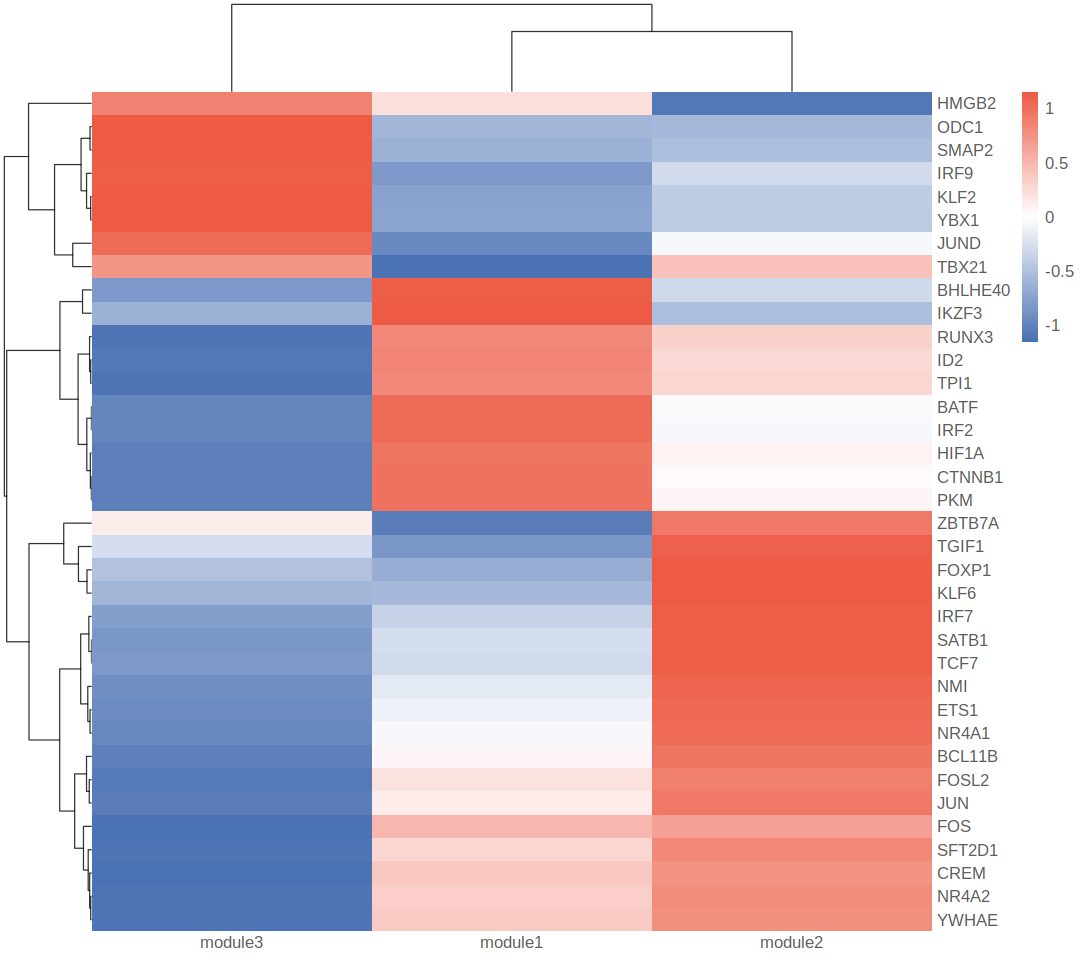

In [53]:
p<-pheatmap(data, cluster_rows=TRUE, cluster_cols=TRUE, scale='row', color = colorRampPalette(c("#1f4fa1", "white", "#e83217"))(100),   # color = rainbow(n, start=.7, end=.1), 
         show_rownames=TRUE, show_colnames=TRUE, border_col=NA,angle_col=0, fontsize=10, silent=TRUE, alpha=0.8)
p

In [55]:
pdf('/home/zhaoyp/collaboration/haorui/res/tf.heatmap.pdf', width=5.5, height=5)
grid::grid.newpage()
grid::grid.draw(p$gtable) 
dev.off()


pdf 
  2